# Simulating fly-bys

This notebook will take you through a simulation of fly-bys of a star perturbing a planetary system.

### Imports

In [6]:
import rebound
import numpy as np
from scipy import spatial

from IPython.display import display, clear_output
import matplotlib.pyplot as plt

In [18]:
import pickle

In [27]:
with open('sim_results_i90_t_max_10_5_3.pickle', 'wb') as handle:
    pickle.dump(stripped_results, handle)

In [80]:
results

[{'sim': 0,
  'intruder': 0,
  'close_encounters': [],
  'escapes': [1090.2273526322256],
  'v_escapes': [],
  'kozai': [],
  'orbit_crossing': [],
  'stable_after_fly_by': False},
 {'sim': 0,
  'intruder': 0,
  'close_encounters': [],
  'escapes': [1011.0826108972403],
  'v_escapes': [],
  'kozai': [],
  'orbit_crossing': [],
  'stable_after_fly_by': False},
 {'sim': 0,
  'intruder': 0,
  'close_encounters': [],
  'escapes': [1069.013744923368],
  'v_escapes': [],
  'kozai': [],
  'orbit_crossing': [],
  'stable_after_fly_by': False},
 {'sim': 0,
  'intruder': 0,
  'close_encounters': [],
  'escapes': [1069.5424735605038],
  'v_escapes': [],
  'kozai': [],
  'orbit_crossing': [],
  'stable_after_fly_by': False},
 {'sim': 0,
  'intruder': 0,
  'close_encounters': [],
  'escapes': [1318.2226662217256, 1338.2226662217256, 1938.2226662217256],
  'v_escapes': [1048.2226662217256,
   1058.2226662217256,
   1068.2226662217256,
   1078.2226662217256,
   1088.2226662217256,
   1098.22266622172

In [25]:
stripped_results

[{'sim': 0,
  'intruder': 1,
  'close_encounters': [],
  'escapes': [1025.3290192757418],
  'v_escapes': [500.0,
   510.0,
   520.0,
   530.0,
   540.0,
   550.0,
   560.0,
   570.0,
   580.0,
   590.0,
   600.0,
   610.0,
   620.0,
   630.0,
   640.0,
   650.0,
   660.0,
   670.0,
   680.0,
   690.0,
   700.0,
   710.0,
   720.0,
   730.0,
   740.0,
   750.0,
   760.0,
   770.0,
   780.0,
   790.0,
   800.0,
   810.0,
   820.0,
   830.0,
   840.0,
   850.0,
   860.0,
   870.0,
   880.0,
   890.0,
   900.0,
   910.0,
   920.0,
   930.0,
   940.0,
   950.0,
   960.0,
   970.0,
   980.0,
   990.0,
   1000.0,
   1010.0,
   1020.0],
  'kozai': [],
  'orbit_crossing': [],
  'stable_after_fly_by': False},
 {'sim': 0,
  'intruder': 1,
  'close_encounters': [1037.8221579197616,
   1070.976810159171,
   1104.1308386920805,
   1137.2848432099242,
   1170.4388578372757,
   1203.5928643419875,
   1236.7468743026814,
   1269.9008866440709,
   1303.0548953018963,
   1336.2089057142075,
   1369.36291

In [19]:
stripped_results = results.copy()
for result in stripped_results:
    result["sim"] = 0
    result["intruder"] = 1


### Setup
Let's first create a simulation of our target planetary system. We'll use Sun and the outer planets of our solar system for now. Using NASA Horizons database to get the details of each object.

In [2]:
sim = rebound.Simulation()
particle_names = ["Sun", "Jupiter", "Saturn", "Uranus", "Neptune"]
# we use the NASA horizon database to look up the Sun and planets
sim.add(particle_names)

# let's give all the particles a unique hash (based on its name)
for i, particle in enumerate(sim.particles):
    particle.hash = particle_names[i]

sim.status()
    

Searching NASA Horizons for 'Sun'... 

KeyboardInterrupt: 

Let's save this simulation for future reference.

In [6]:
sim.save("solar_system_outer_planets.bin")

In [22]:
sim = rebound.Simulation.from_file("solar_system_outer_planets.bin")
sim.integrate(10**6)
sim.status()

---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0000000000000000e+06
Current timestep:    	1.922840
---------------------------------
<rebound.Particle object, m=1.0 x=1.8571023142313239 y=4.505158999518282 z=0.05579575801210394 vx=0.00010973285292743885 vy=-0.0004353304883274691 vz=2.066748558783543e-06>
<rebound.Particle object, m=0.0009547919152112404 x=6.8147702502840595 y=6.73118953776824 z=-0.07725869827938392 vx=-0.17315013118184355 vy=0.38141414608509566 vz=-0.00032924316529987395>
<rebound.Particle object, m=0.0002858856727222417 x=9.322714404062348 y=-0.8332873658381746 z=-0.24580494591406266 vx=0.21018085977735299 vy=0.2627479070254194 vz=-0.006398792605082137>
<rebound.Particle object, m=4.36624373583127e-05 x=-15.44022591324002 y=13.728660728813322 z=0.2217606828122171 vx=-0.1069942017683012 vy=-0.1960591412410102 vz=0.008071389951229656>
<re

Let's define a function that simulates a single fly-by given a certain system and a particle that will be intruding the system.

In [3]:
def simulate_fly_by(sim, intruder, sim_results, visualize=False):
    
    intruder.hash = "intruder"
    sim.add(intruder)
    
    intruder_distance = np.linalg.norm(sim.particles["intruder"].xyz)
    sim.exit_max_distance = intruder_distance*1.01
    
    while True:
        try:
            sim.integrate(sim.t+10)
            
            test_sim = sim.copy()
            test_sim.remove(hash="intruder")
            if check_immediate_ejection(test_sim):
                sim_results["v_escapes"].append(sim.t)
            
            if check_orbit_crossing(test_sim):
                sim_results["orbit_crossing"].append(sim.t)

            if check_kozai(test_sim):
                sim_results["kozai"].append(sim.t)
            
            if visualize:
                fig = rebound.OrbitPlot(sim,color=True,unitlabel="[AU]")
                display(fig)
                plt.close(fig)
                clear_output(wait=True)

        except rebound.Escape as error:
            if type(rebound.Escape()) == type(error):
                print("joe")
            # remove intruder
            sim.remove(hash="intruder")
            sim.move_to_com()
                    
            return sim


In [4]:
def evolve_system(sim, t, sim_results):
    sim.exit_max_distance = 500
    
    close_encounters = []
    ejections = []
    # set planet radii to their hill spheres
    for planet in sim.particles[1:]:
        planet.r = planet.rhill
        
    sim.collision = "direct"
    
    end_time = sim.t + t
    while sim.t < end_time:
        try:
            sim.integrate(sim.t + 10)
            
            if check_immediate_ejection(sim):
                sim_results["v_escapes"].append(sim.t)
            
            if check_orbit_crossing(sim.copy()):
                sim_results["orbit_crossing"].append(sim.t)

            if check_kozai(sim):
                sim_results["kozai"].append(sim.t)
            
        except (rebound.Collision, rebound.Escape) as error:
            #sim.status()
            if type(error) == type(rebound.Collision()):
                print(error, sim.t)
                collided = []
                for particle in sim.particles:
                    if particle.lastcollision == sim.t:
                        collided.append(particle.index)
                
                planet_1 = sim.particles[collided[0]]
                planet_2 = sim.particles[collided[1]]
                
                d = np.linalg.norm(np.array(planet_1.xyz) - np.array(planet_2.xyz))
                print(planet_1.index, planet_2.index, "close encounter. distance:", d)
            
                resolve_collision(sim)
                close_encounters.append(((planet_1.index, planet_2.index), d, sim.t))
                sim_results["close_encounters"].append(sim.t)
            
            else:
                print(error)
                out_of_bounds = []
                for i, particle in enumerate(sim.particles):
                    distance = np.linalg.norm(particle.xyz)
                    if distance > sim.exit_max_distance:
                        print("Removed", particle.index, str(particle.hash))
                        out_of_bounds.append(particle.hash)
                        ejections.append((particle.index, particle.xyz, sim.t))
                
                for hsh in out_of_bounds:
                        sim.remove(hash=hsh)
                        sim.move_to_com()
                        
                sim_results["escapes"].append(sim.t)
                        
    return (sim, close_encounters, ejections, sim_results)
    

In [5]:
def resolve_collision(sim):
    while True:
        try:
            sim.integrate(sim.t+0.1)
            return
        except:
            #  integrate one step without collision detection
            sim.collision = "none"
            sim.step()
            sim.collision = "direct"
            

In [8]:
sim = rebound.Simulation.from_file("solar_system_outer_planets.bin")
intruder = rebound.Particle(m=1.0,x=30.6,y=-1000.,vy=2.)
sim = simulate_fly_by(sim, intruder)

evolve_system(sim, 10**7)

joe


In [29]:
sim = rebound.Simulation.from_file("random_sims/solar_system_outer_planets_5788.bin")
for particle in sim.particles:
    print(particle.hash)
    
sim.status()

c_uint(3000342645)
c_uint(3586273463)
c_uint(4066125545)
c_uint(516400076)
c_uint(1470785325)
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 15:38:54
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	2.9558356028911448e+05
Current timestep:    	1.791724
---------------------------------
<rebound.Particle object, m=1.0 x=0.790392015242414 y=1.2800362480961802 z=0.010029648972591659 vx=-0.00042033941518836116 vy=0.000129634499445474 vz=1.1512510585973728e-05>
<rebound.Particle object, m=0.0009547919152112404 x=-1.62321457248114 y=-3.5400958261243316 z=0.07831235094641473 vx=0.37710694334404987 vy=-0.19041810608900203 vz=-0.008487860358737817>
<rebound.Particle object, m=0.0002858856727222417 x=7.393583393592568 y=-6.584560782884102 z=-0.07737077919291399 vx=0.22619076558664736 vy=0.1970974490642162 vz=-0.012280195894553527>
<rebound.Particle object, m=4.36624373583127e-05 x=20.285578703970426 y=5.068961369614927 z=-

In [16]:
total_simulations = 200
max_evolve_time = 10**5
a_list = np.linspace(0, 100, total_simulations)

results = []


close_encounter_times = []
ejection_times = []

for sim_n in range(total_simulations):
    print(sim_n)
    
    sim_results = get_sim_results_dict()
    random_sim = rebound.Simulation.from_file("random_sims/solar_system_outer_planets_{:04d}.bin".format(np.random.randint(0,10**4)))
    random_sim.t = 0
    sim_results["sim"] = random_sim
    
    intruder = rebound.Particle(m=1.0, x=a_list[sim_n], z=-1000., vz=2.)
    # save a copy of the intruder in sim_results
    sim_results["intruder"] = intruder.copy()
    
    sim = simulate_fly_by(random_sim, intruder, sim_results, visualize=False)
    sim.status()
    sim_results["stable_after_fly_by"] = analyze_stability(sim)
    sim.status()
    result = evolve_system(sim, max_evolve_time, sim_results)
    sim, close_encounters, ejections, sim_results = result
    
    results.append(sim_results)
    
    if close_encounters:
        close_encounter_times.append(close_encounters[0][-1])
        
    if ejection_times:
        ejection_times.append(ejections[0][-1])
        
close_encounter_times.sort()   
fraction_encounters = np.arange(1, len(close_encounter_times) + 1) / total_simulations

ejection_times.sort()
fraction_ejections = np.arange(1, len(ejection_times) + 1) / total_simulations
    
    

0
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 14:05:33
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0253290192757418e+03
Current timestep:    	5.329019
---------------------------------
<rebound.Particle object, m=1.0 x=-0.2728388269898687 y=-0.11859595537833911 z=1.3032976862723444 vx=-0.0005333136078211065 vy=-0.00023878801844628983 vz=0.002465411163836473>
<rebound.Particle object, m=0.0009547919152112404 x=168.6021611707411 y=48.20648394103415 z=-976.3102391535066 vx=0.3316953947128485 vy=0.09184967508324826 vz=-1.8470665040061292>
<rebound.Particle object, m=0.0002858856727222417 x=307.8336140111758 y=163.50238681826303 z=-972.4468344088818 vx=0.6006747031024675 vy=0.334267005904437 vz=-1.8397666671958464>
<rebound.Particle object, m=4.36624373583127e-05 x=262.0745983590864 y=293.8778856896851 z=-975.0390586244724 vx=0.4959959147418108 vy=0.6211942429782582 vz=-1.838543857897675>
<rebound.Partic

/home/starman/.local/lib/python3.6/site-packages/rebound/simulation.py:528: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)


1
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 14:05:33
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0149406482167948e+03
Current timestep:    	0.232014
---------------------------------
<rebound.Particle object, m=1.0 x=-0.01187034963362521 y=-0.11107130442724156 z=0.012648310502747506 vx=0.00017636819134381199 vy=-0.00019823818444297814 vz=1.993171841611907e-05>
<rebound.Particle object, m=0.0009547919152112404 x=-4.777755560028865 y=2.1314406896995024 z=1.0271629873823684 vx=-0.20684405850015616 vy=-0.013463665667981295 vz=0.006169182797952422>
<rebound.Particle object, m=0.0002858856727222417 x=35.05231206067857 y=289.7472712246025 z=-33.50644393660389 vx=0.04857490324452045 vy=0.5606477036863887 vz=-0.06312193027446478>
<rebound.Particle object, m=4.36624373583127e-05 x=41.53688203006191 y=283.74039602960363 z=-41.430076084408306 vx=0.03622858372624713 vy=0.5389455637129734 vz=-0.0795516305343585

Two particles collided (d < r1+r2) 2894.294167046559
0 1 close encounter. distance: 0.2046424691986223
Two particles collided (d < r1+r2) 2927.4481739912676
0 1 close encounter. distance: 0.20464718462517942
Two particles collided (d < r1+r2) 2960.6021868779744
0 1 close encounter. distance: 0.20464347315957554
Two particles collided (d < r1+r2) 2993.756193785003
0 1 close encounter. distance: 0.20464824205778578
Two particles collided (d < r1+r2) 3026.9102047100464
0 1 close encounter. distance: 0.20464731259830685
Two particles collided (d < r1+r2) 3060.0642126961434
0 1 close encounter. distance: 0.2046505512215821
Two particles collided (d < r1+r2) 3093.218226492218
0 1 close encounter. distance: 0.20464555000461723
Two particles collided (d < r1+r2) 3126.3722357488846
0 1 close encounter. distance: 0.20464698664433
Two particles collided (d < r1+r2) 3159.526249182353
0 1 close encounter. distance: 0.20464249977577215
Two particles collided (d < r1+r2) 3192.6802606260203
0 1 close 

Two particles collided (d < r1+r2) 5546.6149880081475
0 1 close encounter. distance: 0.20464333592968412
Two particles collided (d < r1+r2) 5579.768994439238
0 1 close encounter. distance: 0.20464877979218615
Two particles collided (d < r1+r2) 5612.923003010039
0 1 close encounter. distance: 0.20465118916133507
Two particles collided (d < r1+r2) 5646.07701610247
0 1 close encounter. distance: 0.20464718580573496
Two particles collided (d < r1+r2) 5679.231029050109
0 1 close encounter. distance: 0.204643387901285
Two particles collided (d < r1+r2) 5712.385036907795
0 1 close encounter. distance: 0.20464680852830427
Two particles collided (d < r1+r2) 5745.539045606196
0 1 close encounter. distance: 0.20464903689555602
Two particles collided (d < r1+r2) 5778.69305827274
0 1 close encounter. distance: 0.2046456375795933
Two particles collided (d < r1+r2) 5811.84706105662
0 1 close encounter. distance: 0.20465625421708497
Two particles collided (d < r1+r2) 5845.001080697275
0 1 close encoun

Two particles collided (d < r1+r2) 8232.089817147995
0 1 close encounter. distance: 0.20464716633273977
Two particles collided (d < r1+r2) 8265.243822797524
0 1 close encounter. distance: 0.20465371873591776
Two particles collided (d < r1+r2) 8298.397843173647
0 1 close encounter. distance: 0.20463938565759587
Two particles collided (d < r1+r2) 8331.551848297717
0 1 close encounter. distance: 0.20464668296310434
Two particles collided (d < r1+r2) 8364.705859736889
0 1 close encounter. distance: 0.2046450243093571
Two particles collided (d < r1+r2) 8397.859870525963
0 1 close encounter. distance: 0.2046442876280564
Two particles collided (d < r1+r2) 8431.013879273287
0 1 close encounter. distance: 0.20464644653829525
Two particles collided (d < r1+r2) 8464.167888853885
0 1 close encounter. distance: 0.2046474237279981
Two particles collided (d < r1+r2) 8497.321894308232
0 1 close encounter. distance: 0.20465425294649223
Two particles collided (d < r1+r2) 8530.47591085572
0 1 close encou

Two particles collided (d < r1+r2) 10950.718654905506
0 1 close encounter. distance: 0.2046533370127389
Two particles collided (d < r1+r2) 10983.872664740142
0 1 close encounter. distance: 0.20465395392503458
Two particles collided (d < r1+r2) 11017.026682851707
0 1 close encounter. distance: 0.20464283226782928
Two particles collided (d < r1+r2) 11050.180694518302
0 1 close encounter. distance: 0.20464085110254107
Two particles collided (d < r1+r2) 11083.334702394137
0 1 close encounter. distance: 0.20464424587430682
Two particles collided (d < r1+r2) 11116.488705810734
0 1 close encounter. distance: 0.2046539649884422
Two particles collided (d < r1+r2) 11149.642721404485
0 1 close encounter. distance: 0.20464641407304185
Two particles collided (d < r1+r2) 11182.796729885886
0 1 close encounter. distance: 0.20464895011838463
Two particles collided (d < r1+r2) 11215.950738067571
0 1 close encounter. distance: 0.20465191126612248
Two particles collided (d < r1+r2) 11249.10475213957
0 1 

Two particles collided (d < r1+r2) 13669.347501290478
0 1 close encounter. distance: 0.2046472689987652
Two particles collided (d < r1+r2) 13702.501513482826
0 1 close encounter. distance: 0.20464454213021688
Two particles collided (d < r1+r2) 13735.655522053275
0 1 close encounter. distance: 0.20464695182487705
Two particles collided (d < r1+r2) 13768.809534106185
0 1 close encounter. distance: 0.20464442270512626
Two particles collided (d < r1+r2) 13801.963544832217
0 1 close encounter. distance: 0.2046437753718097
Two particles collided (d < r1+r2) 13835.1175524415
0 1 close encounter. distance: 0.2046475482064313
Two particles collided (d < r1+r2) 13868.27156263444
0 1 close encounter. distance: 0.20464765688312814
Two particles collided (d < r1+r2) 13901.425573494957
0 1 close encounter. distance: 0.2046468188294692
Two particles collided (d < r1+r2) 13934.579585333486
0 1 close encounter. distance: 0.20464459375737473
Two particles collided (d < r1+r2) 13967.733588283776
0 1 clos

Two particles collided (d < r1+r2) 16421.130356436297
0 1 close encounter. distance: 0.20464333843024485
Two particles collided (d < r1+r2) 16454.28436111391
0 1 close encounter. distance: 0.20465126898664582
Two particles collided (d < r1+r2) 16487.438376684615
0 1 close encounter. distance: 0.204643750857906
Two particles collided (d < r1+r2) 16520.59238129978
0 1 close encounter. distance: 0.20465176999488663
Two particles collided (d < r1+r2) 16553.74639218889
0 1 close encounter. distance: 0.20465089132865913
Two particles collided (d < r1+r2) 16586.900409497837
0 1 close encounter. distance: 0.20464090802753232
Two particles collided (d < r1+r2) 16620.05442090633
0 1 close encounter. distance: 0.20463929286788837
Two particles collided (d < r1+r2) 16653.208426720612
0 1 close encounter. distance: 0.20464561121477814
Two particles collided (d < r1+r2) 16686.36243825656
0 1 close encounter. distance: 0.20464381521287614
Two particles collided (d < r1+r2) 16719.51644376305
0 1 close

Two particles collided (d < r1+r2) 19172.913206294517
0 1 close encounter. distance: 0.20464690389764112
Two particles collided (d < r1+r2) 19206.067216366388
0 1 close encounter. distance: 0.20464718423808198
Two particles collided (d < r1+r2) 19239.221221836768
0 1 close encounter. distance: 0.20465399061422157
Two particles collided (d < r1+r2) 19272.37523661708
0 1 close encounter. distance: 0.20464759324041568
Two particles collided (d < r1+r2) 19305.52924702855
0 1 close encounter. distance: 0.2046473919565317
Two particles collided (d < r1+r2) 19338.68325916854
0 1 close encounter. distance: 0.20464473928254168
Two particles collided (d < r1+r2) 19371.837263589256
0 1 close encounter. distance: 0.20465303422959105
Two particles collided (d < r1+r2) 19404.99127845401
0 1 close encounter. distance: 0.2046465171272319
Two particles collided (d < r1+r2) 19438.145281716657
0 1 close encounter. distance: 0.20465645465194116
Two particles collided (d < r1+r2) 19471.29929746709
0 1 clos

Two particles collided (d < r1+r2) 21792.080015529547
0 1 close encounter. distance: 0.20464982125244252
Two particles collided (d < r1+r2) 21825.234026354217
0 1 close encounter. distance: 0.204649033907758
Two particles collided (d < r1+r2) 21858.388041036444
0 1 close encounter. distance: 0.2046427758157805
Two particles collided (d < r1+r2) 21891.54204805708
0 1 close encounter. distance: 0.20464738338808625
Two particles collided (d < r1+r2) 21924.696059828977
0 1 close encounter. distance: 0.20464525270626974
Two particles collided (d < r1+r2) 21957.850069094176
0 1 close encounter. distance: 0.20464667700157838
Two particles collided (d < r1+r2) 21991.004077813104
0 1 close encounter. distance: 0.20464887607442073
Two particles collided (d < r1+r2) 22024.158089949527
0 1 close encounter. distance: 0.2046462283956325
Two particles collided (d < r1+r2) 22057.312091654996
0 1 close encounter. distance: 0.20465837440707188
Two particles collided (d < r1+r2) 22090.46611089732
0 1 clo

Two particles collided (d < r1+r2) 24643.32489681863
0 1 close encounter. distance: 0.20465249900047844
Two particles collided (d < r1+r2) 24676.47891172306
0 1 close encounter. distance: 0.20464592560570277
Two particles collided (d < r1+r2) 24709.63292526328
0 1 close encounter. distance: 0.20464128719469432
Two particles collided (d < r1+r2) 24742.78693190948
0 1 close encounter. distance: 0.20464642566319488
Two particles collided (d < r1+r2) 24775.940945570946
0 1 close encounter. distance: 0.2046416151909944
Two particles collided (d < r1+r2) 24809.094954498836
0 1 close encounter. distance: 0.20464351778715695
Two particles collided (d < r1+r2) 24842.24896059206
0 1 close encounter. distance: 0.20464944054718898
Two particles collided (d < r1+r2) 24875.402971057345
0 1 close encounter. distance: 0.20464916289399515
Two particles collided (d < r1+r2) 24908.55698474813
0 1 close encounter. distance: 0.2046443107990529
Two particles collided (d < r1+r2) 24941.71099014661
0 1 close 

Two particles collided (d < r1+r2) 27395.107754479475
0 1 close encounter. distance: 0.20464499049963517
Two particles collided (d < r1+r2) 27428.26176687652
0 1 close encounter. distance: 0.2046419732031319
Two particles collided (d < r1+r2) 27461.415769805146
0 1 close encounter. distance: 0.2046523840778077
Two particles collided (d < r1+r2) 27494.569783294257
0 1 close encounter. distance: 0.20464781790148573
Two particles collided (d < r1+r2) 27527.723798967716
0 1 close encounter. distance: 0.20464015408030228
Two particles collided (d < r1+r2) 27560.877804766264
0 1 close encounter. distance: 0.20464649461768689
Two particles collided (d < r1+r2) 27594.03181670629
0 1 close encounter. distance: 0.20464412541325058
Two particles collided (d < r1+r2) 27627.18582436901
0 1 close encounter. distance: 0.20464782233278528
Two particles collided (d < r1+r2) 27660.339840642755
0 1 close encounter. distance: 0.20463930718577533
Two particles collided (d < r1+r2) 27693.49384755099
0 1 clo

Two particles collided (d < r1+r2) 30213.198622254557
0 1 close encounter. distance: 0.20465226354975993
Two particles collided (d < r1+r2) 30246.352635541036
0 1 close encounter. distance: 0.20464798470523768
Two particles collided (d < r1+r2) 30279.506644779525
0 1 close encounter. distance: 0.2046494468203875
Two particles collided (d < r1+r2) 30312.66065371724
0 1 close encounter. distance: 0.2046513355115697
Two particles collided (d < r1+r2) 30345.814666070866
0 1 close encounter. distance: 0.20464837968036953
Two particles collided (d < r1+r2) 30378.96867549691
0 1 close encounter. distance: 0.2046495758480617
Two particles collided (d < r1+r2) 30412.12268642654
0 1 close encounter. distance: 0.20464863955046
Two particles collided (d < r1+r2) 30445.27669755013
0 1 close encounter. distance: 0.2046474281785085
Two particles collided (d < r1+r2) 30478.43070567998
0 1 close encounter. distance: 0.20465046262999326
Two particles collided (d < r1+r2) 30511.584720968927
0 1 close enc

Two particles collided (d < r1+r2) 32832.36543617697
0 1 close encounter. distance: 0.2046485233980651
Two particles collided (d < r1+r2) 32865.5194520016
0 1 close encounter. distance: 0.2046406450442498
Two particles collided (d < r1+r2) 32898.67345841395
0 1 close encounter. distance: 0.20464611498280028
Two particles collided (d < r1+r2) 32931.827464841284
0 1 close encounter. distance: 0.2046515638596893
Two particles collided (d < r1+r2) 32964.98147369086
0 1 close encounter. distance: 0.2046535776117707
Two particles collided (d < r1+r2) 32998.13548891299
0 1 close encounter. distance: 0.20464655348652105
Two particles collided (d < r1+r2) 33031.28950161299
0 1 close encounter. distance: 0.2046431064993342
Two particles collided (d < r1+r2) 33064.44350848764
0 1 close encounter. distance: 0.20464792100165577
Two particles collided (d < r1+r2) 33097.59751625914
0 1 close encounter. distance: 0.20465146369970177
Two particles collided (d < r1+r2) 33130.75152830387
0 1 close encoun

Two particles collided (d < r1+r2) 35617.302299697956
0 1 close encounter. distance: 0.2046472600453195
Two particles collided (d < r1+r2) 35650.456315199684
0 1 close encounter. distance: 0.2046398396802627
Two particles collided (d < r1+r2) 35683.610323436726
0 1 close encounter. distance: 0.2046427218020182
Two particles collided (d < r1+r2) 35716.76433108615
0 1 close encounter. distance: 0.20464643736251764
Two particles collided (d < r1+r2) 35749.91834212991
0 1 close encounter. distance: 0.2046453391370585
Two particles collided (d < r1+r2) 35783.07235107881
0 1 close encounter. distance: 0.2046472119036905
Two particles collided (d < r1+r2) 35816.22636344149
0 1 close encounter. distance: 0.20464424313223467
Two particles collided (d < r1+r2) 35849.38036723433
0 1 close encounter. distance: 0.20465342835315503
Two particles collided (d < r1+r2) 35882.53438416571
0 1 close encounter. distance: 0.2046439801545086
Two particles collided (d < r1+r2) 35915.68839584673
0 1 close enco

Two particles collided (d < r1+r2) 38369.0851495864
0 1 close encounter. distance: 0.20465076420383382
Two particles collided (d < r1+r2) 38402.23916145278
0 1 close encounter. distance: 0.2046484993150655
Two particles collided (d < r1+r2) 38435.39317394117
0 1 close encounter. distance: 0.20464535229080882
Two particles collided (d < r1+r2) 38468.54717732339
0 1 close encounter. distance: 0.2046551199251173
Two particles collided (d < r1+r2) 38501.70119136125
0 1 close encounter. distance: 0.204649775379342
Two particles collided (d < r1+r2) 38534.85520541512
0 1 close encounter. distance: 0.2046444081754314
Two particles collided (d < r1+r2) 38568.00921332523
0 1 close encounter. distance: 0.20464775405938346
Two particles collided (d < r1+r2) 38601.163223627664
0 1 close encounter. distance: 0.20464770717308658
Two particles collided (d < r1+r2) 38634.317236807445
0 1 close encounter. distance: 0.2046435796057013
Two particles collided (d < r1+r2) 38667.47124329459
0 1 close encoun

Two particles collided (d < r1+r2) 41154.022015477196
0 1 close encounter. distance: 0.20464613452732372
Two particles collided (d < r1+r2) 41187.176024072214
0 1 close encounter. distance: 0.2046485090604163
Two particles collided (d < r1+r2) 41220.33003978572
0 1 close encounter. distance: 0.2046407881847887
Two particles collided (d < r1+r2) 41253.48404362838
0 1 close encounter. distance: 0.20464990250817222
Two particles collided (d < r1+r2) 41286.63805678042
0 1 close encounter. distance: 0.20464581428003
Two particles collided (d < r1+r2) 41319.792063875204
0 1 close encounter. distance: 0.20465031651804014
Two particles collided (d < r1+r2) 41352.94607547736
0 1 close encounter. distance: 0.2046484262942221
Two particles collided (d < r1+r2) 41386.10008942518
0 1 close encounter. distance: 0.20464320952525147
Two particles collided (d < r1+r2) 41419.25409662678
0 1 close encounter. distance: 0.2046475601776154
Two particles collided (d < r1+r2) 41452.40810860798
0 1 close encou

Two particles collided (d < r1+r2) 43872.65085643813
0 1 close encounter. distance: 0.20464772984304977
Two particles collided (d < r1+r2) 43905.80486563074
0 1 close encounter. distance: 0.20464925685719954
Two particles collided (d < r1+r2) 43938.95888289605
0 1 close encounter. distance: 0.20463933525792743
Two particles collided (d < r1+r2) 43972.11289313882
0 1 close encounter. distance: 0.20463937294674148
Two particles collided (d < r1+r2) 44005.266899084214
0 1 close encounter. distance: 0.2046455049744594
Two particles collided (d < r1+r2) 44038.42091014337
0 1 close encounter. distance: 0.20464438482026423
Two particles collided (d < r1+r2) 44071.57492126321
0 1 close encounter. distance: 0.2046431787088952
Two particles collided (d < r1+r2) 44104.728930955614
0 1 close encounter. distance: 0.20464399692850485
Two particles collided (d < r1+r2) 44137.882932619716
0 1 close encounter. distance: 0.204656201219686
Two particles collided (d < r1+r2) 44171.03694757086
0 1 close en

Two particles collided (d < r1+r2) 46657.58772060875
0 1 close encounter. distance: 0.20464553368249783
Two particles collided (d < r1+r2) 46690.74172886926
0 1 close encounter. distance: 0.20464838254021123
Two particles collided (d < r1+r2) 46723.895739902284
0 1 close encounter. distance: 0.20464729944678456
Two particles collided (d < r1+r2) 46757.0497568976
0 1 close encounter. distance: 0.20463776083110868
Two particles collided (d < r1+r2) 46790.20375958443
0 1 close encounter. distance: 0.20464851412925325
Two particles collided (d < r1+r2) 46823.3577678239
0 1 close encounter. distance: 0.20465139292391568
Two particles collided (d < r1+r2) 46856.51177850423
0 1 close encounter. distance: 0.20465080993771
Two particles collided (d < r1+r2) 46889.6657923543
0 1 close encounter. distance: 0.20464573163640784
Two particles collided (d < r1+r2) 46922.81980608949
0 1 close encounter. distance: 0.20464081643091017
Two particles collided (d < r1+r2) 46955.97381040059
0 1 close encoun

Two particles collided (d < r1+r2) 49442.524584121384
0 1 close encounter. distance: 0.20464426761424329
Two particles collided (d < r1+r2) 49475.67859052337
0 1 close encounter. distance: 0.20464975227942764
Two particles collided (d < r1+r2) 49508.832601270944
0 1 close encounter. distance: 0.2046490740078067
Two particles collided (d < r1+r2) 49541.986614328496
0 1 close encounter. distance: 0.2046451197203259
Two particles collided (d < r1+r2) 49575.14062257144
0 1 close encounter. distance: 0.20464799349733948
Two particles collided (d < r1+r2) 49608.29463619727
0 1 close encounter. distance: 0.20464323325457454
Two particles collided (d < r1+r2) 49641.448638639034
0 1 close encounter. distance: 0.20465433430842608
Two particles collided (d < r1+r2) 49674.60265544273
0 1 close encounter. distance: 0.20464506702624483
Two particles collided (d < r1+r2) 49707.75666403026
0 1 close encounter. distance: 0.20464745201461212
Two particles collided (d < r1+r2) 49740.91067628593
0 1 close

Two particles collided (d < r1+r2) 52227.461447216156
0 1 close encounter. distance: 0.2046435911642761
Two particles collided (d < r1+r2) 52260.615455500825
0 1 close encounter. distance: 0.20464640562883443
Two particles collided (d < r1+r2) 52293.76946295379
0 1 close encounter. distance: 0.20465039975377589
Two particles collided (d < r1+r2) 52326.923474278294
0 1 close encounter. distance: 0.2046489032392205
Two particles collided (d < r1+r2) 52360.07748490289
0 1 close encounter. distance: 0.2046483992980688
Two particles collided (d < r1+r2) 52393.23149836104
0 1 close encounter. distance: 0.20464387683076235
Two particles collided (d < r1+r2) 52426.385508509375
0 1 close encounter. distance: 0.20464404838772204
Two particles collided (d < r1+r2) 52459.53951773886
0 1 close encounter. distance: 0.20464552295229974
Two particles collided (d < r1+r2) 52492.693527876734
0 1 close encounter. distance: 0.2046457091924833
Two particles collided (d < r1+r2) 52525.847538975526
0 1 close

Two particles collided (d < r1+r2) 55012.398303700764
0 1 close encounter. distance: 0.2046522881026147
Two particles collided (d < r1+r2) 55045.5523206725
0 1 close encounter. distance: 0.20464278254022777
Two particles collided (d < r1+r2) 55078.70632368564
0 1 close encounter. distance: 0.20465307326200027
Two particles collided (d < r1+r2) 55111.860342935324
0 1 close encounter. distance: 0.20464033719982755
Two particles collided (d < r1+r2) 55145.014344915384
0 1 close encounter. distance: 0.2046520929112502
Two particles collided (d < r1+r2) 55178.16836353058
0 1 close encounter. distance: 0.20464025664312546
Two particles collided (d < r1+r2) 55211.3223704703
0 1 close encounter. distance: 0.2046449785392441
Two particles collided (d < r1+r2) 55244.47637665841
0 1 close encounter. distance: 0.20465076649691713
Two particles collided (d < r1+r2) 55277.63038855031
0 1 close encounter. distance: 0.20464846521507796
Two particles collided (d < r1+r2) 55310.7843994188
0 1 close enco

Two particles collided (d < r1+r2) 57797.335166606135
0 1 close encounter. distance: 0.20465187549592245
Two particles collided (d < r1+r2) 57830.489181105775
0 1 close encounter. distance: 0.2046458757848108
Two particles collided (d < r1+r2) 57863.64318791631
0 1 close encounter. distance: 0.20465078098270587
Two particles collided (d < r1+r2) 57896.79720162877
0 1 close encounter. distance: 0.20464589777775757
Two particles collided (d < r1+r2) 57929.951209235915
0 1 close encounter. distance: 0.2046496731300201
Two particles collided (d < r1+r2) 57963.10522135133
0 1 close encounter. distance: 0.20464705475199257
Two particles collided (d < r1+r2) 57996.259236715196
0 1 close encounter. distance: 0.2046398294948432
Two particles collided (d < r1+r2) 58029.413240027745
0 1 close encounter. distance: 0.2046496953235342
Two particles collided (d < r1+r2) 58062.567258295385
0 1 close encounter. distance: 0.20463835213077045
Two particles collided (d < r1+r2) 58095.7212661649
0 1 close 

Two particles collided (d < r1+r2) 60582.272035371265
0 1 close encounter. distance: 0.2046431504941864
Two particles collided (d < r1+r2) 60615.42604279295
0 1 close encounter. distance: 0.2046471887033342
Two particles collided (d < r1+r2) 60648.580052072604
0 1 close encounter. distance: 0.20464859204531985
Two particles collided (d < r1+r2) 60681.73405758923
0 1 close encounter. distance: 0.20465533240161551
Two particles collided (d < r1+r2) 60714.88807141006
0 1 close encounter. distance: 0.20465029528010556
Two particles collided (d < r1+r2) 60748.042087530666
0 1 close encounter. distance: 0.2046419967872812
Two particles collided (d < r1+r2) 60781.196091300764
0 1 close encounter. distance: 0.20465121382400112
Two particles collided (d < r1+r2) 60814.350106184545
0 1 close encounter. distance: 0.20464466925035965
Two particles collided (d < r1+r2) 60847.50412057967
0 1 close encounter. distance: 0.2046388180010041
Two particles collided (d < r1+r2) 60880.65812097094
0 1 close 

Two particles collided (d < r1+r2) 63367.20889833732
0 1 close encounter. distance: 0.20464264544256086
Two particles collided (d < r1+r2) 63400.36290609536
0 1 close encounter. distance: 0.20464620668283104
Two particles collided (d < r1+r2) 63433.5169104599
0 1 close encounter. distance: 0.20465458081675456
Two particles collided (d < r1+r2) 63466.67093105278
0 1 close encounter. distance: 0.20463993955711904
Two particles collided (d < r1+r2) 63499.82493684719
0 1 close encounter. distance: 0.20464628557733763
Two particles collided (d < r1+r2) 63532.97894578179
0 1 close encounter. distance: 0.20464817822512432
Two particles collided (d < r1+r2) 63566.132958092065
0 1 close encounter. distance: 0.20464528349569183
Two particles collided (d < r1+r2) 63599.28697080133
0 1 close encounter. distance: 0.2046418230169078
Two particles collided (d < r1+r2) 63632.44097205005
0 1 close encounter. distance: 0.20465461602490648
Two particles collided (d < r1+r2) 63665.59498716193
0 1 close en

Two particles collided (d < r1+r2) 66152.14575553562
0 1 close encounter. distance: 0.2046503188172043
Two particles collided (d < r1+r2) 66185.2997682384
0 1 close encounter. distance: 0.20464686756147601
Two particles collided (d < r1+r2) 66218.45378049559
0 1 close encounter. distance: 0.2046440481578453
Two particles collided (d < r1+r2) 66251.60779486949
0 1 close encounter. distance: 0.204638226920726
Two particles collided (d < r1+r2) 66284.7617967373
0 1 close encounter. distance: 0.20465014149635505
Two particles collided (d < r1+r2) 66317.9158112158
0 1 close encounter. distance: 0.20464417159638512
Two particles collided (d < r1+r2) 66351.06982079687
0 1 close encounter. distance: 0.2046451474911224
Two particles collided (d < r1+r2) 66384.2238298302
0 1 close encounter. distance: 0.2046469001630027
Two particles collided (d < r1+r2) 66417.3778415898
0 1 close encounter. distance: 0.20464478653902501
Two particles collided (d < r1+r2) 66450.53185083768
0 1 close encounter. d

Two particles collided (d < r1+r2) 68903.92861047992
0 1 close encounter. distance: 0.20464662173438572
Two particles collided (d < r1+r2) 68937.08261704094
0 1 close encounter. distance: 0.20465188076200808
Two particles collided (d < r1+r2) 68970.23663562142
0 1 close encounter. distance: 0.20464009361474153
Two particles collided (d < r1+r2) 69003.39063980027
0 1 close encounter. distance: 0.20464873073657294
Two particles collided (d < r1+r2) 69036.54465277327
0 1 close encounter. distance: 0.2046448959147586
Two particles collided (d < r1+r2) 69069.69865910505
0 1 close encounter. distance: 0.20465047995737518
Two particles collided (d < r1+r2) 69102.85267256844
0 1 close encounter. distance: 0.20464594956993987
Two particles collided (d < r1+r2) 69136.00667761744
0 1 close encounter. distance: 0.20465335296550227
Two particles collided (d < r1+r2) 69169.16069857926
0 1 close encounter. distance: 0.20463818846292836
Two particles collided (d < r1+r2) 69202.3147058134
0 1 close enc

Two particles collided (d < r1+r2) 71622.55745150277
0 1 close encounter. distance: 0.20464810022240332
Two particles collided (d < r1+r2) 71655.71146520307
0 1 close encounter. distance: 0.20464323394259198
Two particles collided (d < r1+r2) 71688.86547379941
0 1 close encounter. distance: 0.20464560620512826
Two particles collided (d < r1+r2) 71722.01947924458
0 1 close encounter. distance: 0.20465244747859557
Two particles collided (d < r1+r2) 71755.1734935928
0 1 close encounter. distance: 0.2046466622787518
Two particles collided (d < r1+r2) 71788.32750501917
0 1 close encounter. distance: 0.20464502087393605
Two particles collided (d < r1+r2) 71821.48151416471
0 1 close encounter. distance: 0.2046466141334409
Two particles collided (d < r1+r2) 71854.635529713
0 1 close encounter. distance: 0.20463912740268736
Two particles collided (d < r1+r2) 71887.7895389428
0 1 close encounter. distance: 0.204640601258165
Two particles collided (d < r1+r2) 71920.9435506415
0 1 close encounter.

Two particles collided (d < r1+r2) 74407.4943155498
0 1 close encounter. distance: 0.20464605018820367
Two particles collided (d < r1+r2) 74440.64832421471
0 1 close encounter. distance: 0.2046483253044289
Two particles collided (d < r1+r2) 74473.80234051781
0 1 close encounter. distance: 0.20463976800994677
Two particles collided (d < r1+r2) 74506.95634278834
0 1 close encounter. distance: 0.20465111147611323
Two particles collided (d < r1+r2) 74540.11035715656
0 1 close encounter. distance: 0.20464529797363376
Two particles collided (d < r1+r2) 74573.26437504552
0 1 close encounter. distance: 0.20463449181629573
Two particles collided (d < r1+r2) 74606.41837724084
0 1 close encounter. distance: 0.20464594159161026
Two particles collided (d < r1+r2) 74639.57239143866
0 1 close encounter. distance: 0.20464036989757634
Two particles collided (d < r1+r2) 74672.72639810841
0 1 close encounter. distance: 0.20464547424320514
Two particles collided (d < r1+r2) 74705.88040799742
0 1 close enc

Two particles collided (d < r1+r2) 77192.43118133709
0 1 close encounter. distance: 0.20464153093380846
Two particles collided (d < r1+r2) 77225.58518439089
0 1 close encounter. distance: 0.20465176376120942
Two particles collided (d < r1+r2) 77258.73919731108
0 1 close encounter. distance: 0.20464800393666188
Two particles collided (d < r1+r2) 77291.89320591613
0 1 close encounter. distance: 0.2046503638014424
Two particles collided (d < r1+r2) 77325.0472217697
0 1 close encounter. distance: 0.20464244384378968
Two particles collided (d < r1+r2) 77358.201227714
0 1 close encounter. distance: 0.20464857705673467
Two particles collided (d < r1+r2) 77391.35523871475
0 1 close encounter. distance: 0.20464753924305185
Two particles collided (d < r1+r2) 77424.5092540698
0 1 close encounter. distance: 0.20464032621425127
Two particles collided (d < r1+r2) 77457.66326106289
0 1 close encounter. distance: 0.20464497210117424
Two particles collided (d < r1+r2) 77490.81727520602
0 1 close encoun

Two particles collided (d < r1+r2) 79977.36804049161
0 1 close encounter. distance: 0.20464641578524256
Two particles collided (d < r1+r2) 80010.52204994032
0 1 close encounter. distance: 0.2046475790628413
Two particles collided (d < r1+r2) 80043.67606419521
0 1 close encounter. distance: 0.20464192626758346
Two particles collided (d < r1+r2) 80076.83007398157
0 1 close encounter. distance: 0.20464261085595797
Two particles collided (d < r1+r2) 80109.98408053689
0 1 close encounter. distance: 0.20464787756731584
Two particles collided (d < r1+r2) 80143.13808779937
0 1 close encounter. distance: 0.20465214148594615
Two particles collided (d < r1+r2) 80176.29210465113
0 1 close encounter. distance: 0.20464280569595855
Two particles collided (d < r1+r2) 80209.44610648349
0 1 close encounter. distance: 0.2046547708314421
Two particles collided (d < r1+r2) 80242.60012077582
0 1 close encounter. distance: 0.20464906476699138
Two particles collided (d < r1+r2) 80275.75413671334
0 1 close enc

Two particles collided (d < r1+r2) 82695.99688742457
0 1 close encounter. distance: 0.20463950246806092
Two particles collided (d < r1+r2) 82729.15089148692
0 1 close encounter. distance: 0.20464830475181997
Two particles collided (d < r1+r2) 82762.30490348166
0 1 close encounter. distance: 0.20464585723962017
Two particles collided (d < r1+r2) 82795.45891162092
0 1 close encounter. distance: 0.20464887759545938
Two particles collided (d < r1+r2) 82828.61292288855
0 1 close encounter. distance: 0.20464746134477405
Two particles collided (d < r1+r2) 82861.76693470123
0 1 close encounter. distance: 0.20464527224054768
Two particles collided (d < r1+r2) 82894.9209500147
0 1 close encounter. distance: 0.20463811834346687
Two particles collided (d < r1+r2) 82928.07495662257
0 1 close encounter. distance: 0.2046433105254101
Two particles collided (d < r1+r2) 82961.22896541428
0 1 close encounter. distance: 0.2046454056788517
Two particles collided (d < r1+r2) 82994.3829775162
0 1 close encou

Two particles collided (d < r1+r2) 85480.93374051976
0 1 close encounter. distance: 0.2046529739346181
Two particles collided (d < r1+r2) 85514.08775998976
0 1 close encounter. distance: 0.20463992506868686
Two particles collided (d < r1+r2) 85547.24176177691
0 1 close encounter. distance: 0.20465195405571368
Two particles collided (d < r1+r2) 85580.39576876562
0 1 close encounter. distance: 0.20465660634708566
Two particles collided (d < r1+r2) 85613.54978645594
0 1 close encounter. distance: 0.20464608104108917
Two particles collided (d < r1+r2) 85646.7038016072
0 1 close encounter. distance: 0.20463915714256822
Two particles collided (d < r1+r2) 85679.85780253007
0 1 close encounter. distance: 0.20465241190770303
Two particles collided (d < r1+r2) 85713.01181656953
0 1 close encounter. distance: 0.20464706457806162
Two particles collided (d < r1+r2) 85746.16582891098
0 1 close encounter. distance: 0.20464412522138964
Two particles collided (d < r1+r2) 85779.3198345907
0 1 close enco

Two particles collided (d < r1+r2) 88265.87060422935
0 1 close encounter. distance: 0.20465138944171932
Two particles collided (d < r1+r2) 88299.0246245962
0 1 close encounter. distance: 0.2046370688840842
Two particles collided (d < r1+r2) 88332.17862873686
0 1 close encounter. distance: 0.204645759929561
Two particles collided (d < r1+r2) 88365.33263263329
0 1 close encounter. distance: 0.2046547975181195
Two particles collided (d < r1+r2) 88398.48664624132
0 1 close encounter. distance: 0.20465006199165442
Two particles collided (d < r1+r2) 88431.64065577002
0 1 close encounter. distance: 0.20465111183234627
Two particles collided (d < r1+r2) 88464.79466702267
0 1 close encounter. distance: 0.20464971686740707
Two particles collided (d < r1+r2) 88497.94867947849
0 1 close encounter. distance: 0.20464661529794073
Two particles collided (d < r1+r2) 88531.10268984105
0 1 close encounter. distance: 0.20464648248806502
Two particles collided (d < r1+r2) 88564.2567002306
0 1 close encount

Two particles collided (d < r1+r2) 91050.80746878147
0 1 close encounter. distance: 0.2046486070204894
Two particles collided (d < r1+r2) 91083.9614832035
0 1 close encounter. distance: 0.20464271718790386
Two particles collided (d < r1+r2) 91117.11549012401
0 1 close encounter. distance: 0.20464746592915845
Two particles collided (d < r1+r2) 91150.26949386456
0 1 close encounter. distance: 0.2046567247223091
Two particles collided (d < r1+r2) 91183.42351613592
0 1 close encounter. distance: 0.20463970268310872
Two particles collided (d < r1+r2) 91216.5775240697
0 1 close encounter. distance: 0.20464301434308355
Two particles collided (d < r1+r2) 91249.73152942181
0 1 close encounter. distance: 0.20464998740973667
Two particles collided (d < r1+r2) 91282.88554326435
0 1 close encounter. distance: 0.20464491928795567
Two particles collided (d < r1+r2) 91316.0395485645
0 1 close encounter. distance: 0.2046519661908161
Two particles collided (d < r1+r2) 91349.19355936105
0 1 close encount

Two particles collided (d < r1+r2) 93802.5903261583
0 1 close encounter. distance: 0.20464143456497066
Two particles collided (d < r1+r2) 93835.74432930956
0 1 close encounter. distance: 0.20465152894277086
Two particles collided (d < r1+r2) 93868.89834728096
0 1 close encounter. distance: 0.20464060519378927
Two particles collided (d < r1+r2) 93902.05235788586
0 1 close encounter. distance: 0.20464012863389305
Two particles collided (d < r1+r2) 93935.20636561593
0 1 close encounter. distance: 0.2046437290655832
Two particles collided (d < r1+r2) 93968.36037787083
0 1 close encounter. distance: 0.20464091258192718
Two particles collided (d < r1+r2) 94001.51438373254
0 1 close encounter. distance: 0.20464716266149494
Two particles collided (d < r1+r2) 94034.66839342953
0 1 close encounter. distance: 0.20464797372261623
Two particles collided (d < r1+r2) 94067.82240753825
0 1 close encounter. distance: 0.20464252813630146
Two particles collided (d < r1+r2) 94100.9764199945
0 1 close enco

Two particles collided (d < r1+r2) 96587.52718157458
0 1 close encounter. distance: 0.20465160017266953
Two particles collided (d < r1+r2) 96620.68119529077
0 1 close encounter. distance: 0.20464671105171792
Two particles collided (d < r1+r2) 96653.83520950848
0 1 close encounter. distance: 0.2046411108880906
Two particles collided (d < r1+r2) 96686.98922074812
0 1 close encounter. distance: 0.2046397341704563
Two particles collided (d < r1+r2) 96720.14322657401
0 1 close encounter. distance: 0.2046460351893067
Two particles collided (d < r1+r2) 96753.29724272981
0 1 close encounter. distance: 0.2046376865849866
Two particles collided (d < r1+r2) 96786.45125116984
0 1 close encounter. distance: 0.2046402799757119
Two particles collided (d < r1+r2) 96819.60525720437
0 1 close encounter. distance: 0.2046462850697901
Two particles collided (d < r1+r2) 96852.75926347103
0 1 close encounter. distance: 0.20465196101972752
Two particles collided (d < r1+r2) 96885.9132781674
0 1 close encounte

Two particles collided (d < r1+r2) 99372.46404296577
0 1 close encounter. distance: 0.20465329045907046
Two particles collided (d < r1+r2) 99405.61805944444
0 1 close encounter. distance: 0.20464448365147356
Two particles collided (d < r1+r2) 99438.7720675217
0 1 close encounter. distance: 0.20464759174737646
Two particles collided (d < r1+r2) 99471.9260776355
0 1 close encounter. distance: 0.2046478115819695
Two particles collided (d < r1+r2) 99505.08008882972
0 1 close encounter. distance: 0.20464649932514772
Two particles collided (d < r1+r2) 99538.23410020462
0 1 close encounter. distance: 0.2046449306948727
Two particles collided (d < r1+r2) 99571.38811352437
0 1 close encounter. distance: 0.2046406040537491
Two particles collided (d < r1+r2) 99604.54212410763
0 1 close encounter. distance: 0.20464015811988334
Two particles collided (d < r1+r2) 99637.6961319802
0 1 close encounter. distance: 0.20464355635352155
Two particles collided (d < r1+r2) 99670.85014004706
0 1 close encount

A particle escaped (r>exit_max_distance).
Removed 3 c_uint(1470785325)
A particle escaped (r>exit_max_distance).
Removed 2 c_uint(516400076)
A particle escaped (r>exit_max_distance).
Removed 1 c_uint(4066125545)
4
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 14:05:33
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0251519595625136e+03
Current timestep:    	5.151960
---------------------------------
<rebound.Particle object, m=1.0 x=0.390559580061705 y=-0.2656132417819492 z=0.06337542115700501 vx=0.0007444228454771828 vy=-0.0004820821435851941 vz=0.00011813259235914086>
<rebound.Particle object, m=0.0009547919152112404 x=-315.82823067686076 y=186.38844626690457 z=-45.50794140492534 vx=-0.5985751884917476 vy=0.339158813827196 vz=-0.08471171978814712>
<rebound.Particle object, m=0.0002858856727222417 x=-260.03377532852403 y=240.1419324444777 z=-50.75343203283272 vx=-0.5028282610637862 vy=0.4342285734375764 

Two particles collided (d < r1+r2) 10222.856985848424
0 2 close encounter. distance: 0.662213092851563
Two particles collided (d < r1+r2) 10568.084345558098
0 2 close encounter. distance: 0.6585038379109455
Two particles collided (d < r1+r2) 10912.848431932116
0 2 close encounter. distance: 0.6642356200936645
Two particles collided (d < r1+r2) 11257.088394058908
0 2 close encounter. distance: 0.6608846150122347
Two particles collided (d < r1+r2) 11600.634908022665
0 2 close encounter. distance: 0.6632641317576183
Two particles collided (d < r1+r2) 11943.433444404242
0 2 close encounter. distance: 0.658130723743716
Two particles collided (d < r1+r2) 12293.973883166063
0 2 close encounter. distance: 0.6627079570798253
Two particles collided (d < r1+r2) 12643.415333846056
0 2 close encounter. distance: 0.6640715842046366
Two particles collided (d < r1+r2) 59246.02989554657
1 2 close encounter. distance: 1.2504021184222784
6
joe
---------------------------------
REBOUND version:     	3.7.2

Two particles collided (d < r1+r2) 1104.1890601959005
0 3 close encounter. distance: 0.29834964889575294
Two particles collided (d < r1+r2) 1378.899151059095
0 3 close encounter. distance: 0.2960581295598636
Two particles collided (d < r1+r2) 1653.5656127746183
0 3 close encounter. distance: 0.2992126783029748
A particle escaped (r>exit_max_distance).
Removed 2 c_uint(4066125545)
Two particles collided (d < r1+r2) 1928.236822761076
0 2 close encounter. distance: 0.29919427820543837
Two particles collided (d < r1+r2) 2202.907654619491
0 2 close encounter. distance: 0.2991941102955797
Two particles collided (d < r1+r2) 2477.57869550852
0 2 close encounter. distance: 0.2992814826241287
Two particles collided (d < r1+r2) 2752.259580738495
0 2 close encounter. distance: 0.29961217533926654
A particle escaped (r>exit_max_distance).
Removed 1 c_uint(3586273463)
Two particles collided (d < r1+r2) 3026.9411204909134
0 1 close encounter. distance: 0.2996251984035346
Two particles collided (d < r

Two particles collided (d < r1+r2) 22532.211977797055
0 1 close encounter. distance: 0.29509252885270415
Two particles collided (d < r1+r2) 22806.930675963475
0 1 close encounter. distance: 0.2950666184331248
Two particles collided (d < r1+r2) 23081.654159219328
0 1 close encounter. distance: 0.2953155715718489
Two particles collided (d < r1+r2) 23356.383972547923
0 1 close encounter. distance: 0.29553187593023944
Two particles collided (d < r1+r2) 23631.113990551155
0 1 close encounter. distance: 0.2955303768207181
Two particles collided (d < r1+r2) 23905.842583939455
0 1 close encounter. distance: 0.2955161734134411
Two particles collided (d < r1+r2) 24180.583269780003
0 1 close encounter. distance: 0.29592531268650457
Two particles collided (d < r1+r2) 24455.325214332977
0 1 close encounter. distance: 0.29595774432523997
Two particles collided (d < r1+r2) 24730.066583454693
0 1 close encounter. distance: 0.2959468351523483
Two particles collided (d < r1+r2) 25004.810625565973
0 1 cl

Two particles collided (d < r1+r2) 44210.392101616235
0 1 close encounter. distance: 0.2958346217837366
Two particles collided (d < r1+r2) 44484.26505686345
0 1 close encounter. distance: 0.2958613329589486
Two particles collided (d < r1+r2) 44758.14974166692
0 1 close encounter. distance: 0.29629338220979395
Two particles collided (d < r1+r2) 45032.03558127435
0 1 close encounter. distance: 0.2963348399962144
Two particles collided (d < r1+r2) 45305.92082693787
0 1 close encounter. distance: 0.29632023278390446
Two particles collided (d < r1+r2) 45579.80895613926
0 1 close encounter. distance: 0.2965411429439213
Two particles collided (d < r1+r2) 45853.70452153084
0 1 close encounter. distance: 0.2968085207792297
Two particles collided (d < r1+r2) 46127.600436638364
0 1 close encounter. distance: 0.2968402950908413
Two particles collided (d < r1+r2) 46401.494327168475
0 1 close encounter. distance: 0.2966475975691259
Two particles collided (d < r1+r2) 46675.397793871205
0 1 close enco

Two particles collided (d < r1+r2) 66104.65074405062
0 1 close encounter. distance: 0.29939175861996736
Two particles collided (d < r1+r2) 66378.23419019929
0 1 close encounter. distance: 0.299899740011055
Two particles collided (d < r1+r2) 66651.81928408875
0 1 close encounter. distance: 0.29997579106880456
Two particles collided (d < r1+r2) 66925.40407883318
0 1 close encounter. distance: 0.2999555486695743
Two particles collided (d < r1+r2) 67198.98999740125
0 1 close encounter. distance: 0.30010446849401234
Two particles collided (d < r1+r2) 67472.58480332352
0 1 close encounter. distance: 0.30048588663112
Two particles collided (d < r1+r2) 67746.18025626696
0 1 close encounter. distance: 0.30050847968817523
Two particles collided (d < r1+r2) 68019.7740646109
0 1 close encounter. distance: 0.30043088193443857
Two particles collided (d < r1+r2) 68293.37971393125
0 1 close encounter. distance: 0.3010329958528188
Two particles collided (d < r1+r2) 68566.99622727145
0 1 close encounter

Two particles collided (d < r1+r2) 87721.89550895535
0 1 close encounter. distance: 0.29960855970200245
Two particles collided (d < r1+r2) 87995.39533872397
0 1 close encounter. distance: 0.298650966400316
Two particles collided (d < r1+r2) 88268.89699302515
0 1 close encounter. distance: 0.2987506041456818
Two particles collided (d < r1+r2) 88542.3985824838
0 1 close encounter. distance: 0.29874079266435155
Two particles collided (d < r1+r2) 88815.89983958699
0 1 close encounter. distance: 0.298814210089001
Two particles collided (d < r1+r2) 89089.41173213534
0 1 close encounter. distance: 0.29926487754858944
Two particles collided (d < r1+r2) 89362.92462262625
0 1 close encounter. distance: 0.299293800494462
Two particles collided (d < r1+r2) 89636.43669796636
0 1 close encounter. distance: 0.299257831893222
Two particles collided (d < r1+r2) 89909.95340836255
0 1 close encounter. distance: 0.29957505716470656
Two particles collided (d < r1+r2) 90183.47652083136
0 1 close encounter. 

A particle escaped (r>exit_max_distance).
Removed 1 c_uint(3586273463)
A particle escaped (r>exit_max_distance).
Removed 2 c_uint(516400076)
11
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 14:05:33
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0100000000000000e+03
Current timestep:    	5.034149
---------------------------------
<rebound.Particle object, m=1.0 x=0.25008002283324515 y=-0.3151046591953275 z=-0.04805347743420718 vx=0.00048013370602717487 vy=-0.0006058545819538075 vz=-9.309800039570063e-05>
<rebound.Particle object, m=0.0009547919152112404 x=-214.20352290538582 y=355.88869899401305 z=46.623866859136946 vx=-0.4258902946699022 vy=0.6878664170598634 vz=0.09051808381736118>
<rebound.Particle object, m=0.0002858856727222417 x=-138.1589015559584 y=-65.44619407782331 z=10.198714479764707 vx=-0.23661165549179114 vy=-0.1347711908333615 vz=0.019157926068597602>
<rebound.Particle object, m=4.366243735

Two particles collided (d < r1+r2) 30631.49344177359
1 2 close encounter. distance: 0.7679083549411625
Two particles collided (d < r1+r2) 32665.01250538449
1 2 close encounter. distance: 0.8087360157014446
Two particles collided (d < r1+r2) 32952.839344263375
1 2 close encounter. distance: 0.7873610198131543
Two particles collided (d < r1+r2) 33074.96749272621
1 2 close encounter. distance: 0.7778740994551264
Two particles collided (d < r1+r2) 34460.22714591799
1 2 close encounter. distance: 0.7999793707189297
Two particles collided (d < r1+r2) 35911.38954374
1 2 close encounter. distance: 0.7703742917850226
Two particles collided (d < r1+r2) 36184.05514438169
1 2 close encounter. distance: 0.7828233494702294
Two particles collided (d < r1+r2) 36581.50029499036
1 2 close encounter. distance: 0.7829354503075491
Two particles collided (d < r1+r2) 37664.93369298871
1 2 close encounter. distance: 0.7903519421787445
Two particles collided (d < r1+r2) 38498.822146477374
1 2 close encounter. 

A particle escaped (r>exit_max_distance).
Removed 3 c_uint(516400076)
Two particles collided (d < r1+r2) 11722.081596511667
2 3 close encounter. distance: 3.004185988969147
Two particles collided (d < r1+r2) 59919.252204683384
2 3 close encounter. distance: 3.0376861802334663
Two particles collided (d < r1+r2) 85648.72342219835
2 3 close encounter. distance: 3.0707365805114013
15
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 14:05:33
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0053842313656393e+03
Current timestep:    	1.255337
---------------------------------
<rebound.Particle object, m=1.0 x=-0.002133768169983341 y=0.007222238046503682 z=-0.00012697935203487276 vx=-0.00037359319548371794 vy=-0.0002066090025357565 vz=2.518280051401131e-05>
<rebound.Particle object, m=0.0009547919152112404 x=-0.23046363453889285 y=-5.083148506298684 z=0.16037652015984616 vx=0.3890041405178377 vy=0.07145334004734406 v

Two particles collided (d < r1+r2) 50202.5298745282
1 4 close encounter. distance: 0.7159397745895326
Two particles collided (d < r1+r2) 52858.13587501241
1 4 close encounter. distance: 0.7050076379521285
Two particles collided (d < r1+r2) 53890.48438776008
1 4 close encounter. distance: 0.7292073897744501
Two particles collided (d < r1+r2) 56331.95311990829
1 4 close encounter. distance: 0.6764197200358052
Two particles collided (d < r1+r2) 65773.91836588603
1 4 close encounter. distance: 0.7043952291075475
Two particles collided (d < r1+r2) 66284.78344576873
1 4 close encounter. distance: 0.6964942550828013
A particle escaped (r>exit_max_distance).
Removed 4 c_uint(1470785325)
Two particles collided (d < r1+r2) 98510.28839514645
1 2 close encounter. distance: 0.6142487767249911
16
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 14:05:33
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0065628365762826e+03


Two particles collided (d < r1+r2) 75378.07187831278
1 3 close encounter. distance: 0.779211502006902
Two particles collided (d < r1+r2) 75529.69685676377
1 3 close encounter. distance: 0.7687036595992905
Two particles collided (d < r1+r2) 75970.64169092289
1 3 close encounter. distance: 0.7603658638048979
Two particles collided (d < r1+r2) 77888.99528237045
1 3 close encounter. distance: 0.7633487874551965
Two particles collided (d < r1+r2) 78341.12590026534
1 3 close encounter. distance: 0.7568161378324334
Two particles collided (d < r1+r2) 78371.96040437448
2 3 close encounter. distance: 0.8795631798053555
Two particles collided (d < r1+r2) 78935.06834437353
1 3 close encounter. distance: 0.7844004268114582
Two particles collided (d < r1+r2) 79532.3919711308
1 3 close encounter. distance: 0.7848081289772326
Two particles collided (d < r1+r2) 79758.84771292281
1 3 close encounter. distance: 0.7499448989044784
Two particles collided (d < r1+r2) 80134.86379973197
1 3 close encounter. d

A particle escaped (r>exit_max_distance).
Removed 4 c_uint(1470785325)
Two particles collided (d < r1+r2) 37459.67849095242
2 3 close encounter. distance: 0.7641392264130111
Two particles collided (d < r1+r2) 42248.344266878994
2 3 close encounter. distance: 0.7526811428745512
Two particles collided (d < r1+r2) 59921.71548012714
1 2 close encounter. distance: 0.7353935920658742
Two particles collided (d < r1+r2) 64709.356504038056
1 2 close encounter. distance: 0.7317422082865352
Two particles collided (d < r1+r2) 65998.73108762573
1 2 close encounter. distance: 0.7156731700542824
Two particles collided (d < r1+r2) 69025.11828958541
1 2 close encounter. distance: 0.7111415104739207
Two particles collided (d < r1+r2) 73045.67614784617
1 2 close encounter. distance: 0.7055096599422566
Two particles collided (d < r1+r2) 73766.30258032781
1 2 close encounter. distance: 0.7377429118511887
Two particles collided (d < r1+r2) 74534.64451763984
1 2 close encounter. distance: 0.735029222913174
T

Two particles collided (d < r1+r2) 4745.788765687547
0 2 close encounter. distance: 0.7494449541581126
Two particles collided (d < r1+r2) 5185.726857804927
0 2 close encounter. distance: 0.7574984569838575
Two particles collided (d < r1+r2) 5613.231922721612
0 2 close encounter. distance: 0.7540367574341841
Two particles collided (d < r1+r2) 5723.402222215867
1 3 close encounter. distance: 0.5365519713944152
Two particles collided (d < r1+r2) 6028.655522272346
0 2 close encounter. distance: 0.7438763921327597
Two particles collided (d < r1+r2) 6442.96619302015
0 2 close encounter. distance: 0.7422558515900507
Two particles collided (d < r1+r2) 6868.94205680373
0 2 close encounter. distance: 0.7357655725635927
Two particles collided (d < r1+r2) 7287.096116390798
1 3 close encounter. distance: 0.5303319332335221
Two particles collided (d < r1+r2) 7307.427681351241
0 2 close encounter. distance: 0.7437310724442865
Two particles collided (d < r1+r2) 7732.690632592647
0 2 close encounter. d

Two particles collided (d < r1+r2) 37162.00627555685
0 2 close encounter. distance: 0.7519406773236447
Two particles collided (d < r1+r2) 37554.6089316751
0 2 close encounter. distance: 0.7363328604463064
Two particles collided (d < r1+r2) 37956.34904354322
0 2 close encounter. distance: 0.7367297749411484
Two particles collided (d < r1+r2) 38356.0864329852
0 2 close encounter. distance: 0.7591940910123556
Two particles collided (d < r1+r2) 38384.451661224586
1 3 close encounter. distance: 0.5401998600550564
Two particles collided (d < r1+r2) 38764.917167245294
0 2 close encounter. distance: 0.7547777624721989
Two particles collided (d < r1+r2) 38810.356607232876
1 3 close encounter. distance: 0.5468410638733453
Two particles collided (d < r1+r2) 39178.36365810067
0 2 close encounter. distance: 0.7438964657434491
Two particles collided (d < r1+r2) 39577.70875789265
0 2 close encounter. distance: 0.7419086615918327
Two particles collided (d < r1+r2) 39818.11855713178
1 3 close encounter

Two particles collided (d < r1+r2) 66553.98103684474
0 2 close encounter. distance: 0.743647716750914
Two particles collided (d < r1+r2) 66991.80985154491
0 2 close encounter. distance: 0.7555336934753992
Two particles collided (d < r1+r2) 67436.23135338177
0 2 close encounter. distance: 0.7571803958462368
Two particles collided (d < r1+r2) 67864.21663161444
1 3 close encounter. distance: 0.5163473297891917
Two particles collided (d < r1+r2) 67885.1618000805
0 2 close encounter. distance: 0.7384375233816611
Two particles collided (d < r1+r2) 68313.72495313564
0 2 close encounter. distance: 0.740919689676775
Two particles collided (d < r1+r2) 68722.18515475623
0 2 close encounter. distance: 0.7345435049482641
Two particles collided (d < r1+r2) 69139.97762020981
0 2 close encounter. distance: 0.7520873946754678
Two particles collided (d < r1+r2) 69275.31162517231
1 3 close encounter. distance: 0.530219795236772
Two particles collided (d < r1+r2) 69566.0079075211
0 2 close encounter. dist

Two particles collided (d < r1+r2) 100468.5564035395
0 2 close encounter. distance: 0.7445952892902281
21
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 14:05:33
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0051270130202387e+03
Current timestep:    	0.947108
---------------------------------
<rebound.Particle object, m=1.0 x=-0.0018244365260144946 y=0.0009905464848252166 z=-0.00034248297905048464 vx=0.00010518446020264804 vy=-0.00032142646541681585 vz=-1.5114475299517725e-05>
<rebound.Particle object, m=0.0009547919152112404 x=4.8538372135885055 y=5.351595400558681 z=0.26995653347505233 vx=-0.189836054663295 vy=0.35388389358432043 vz=0.01918310789232772>
<rebound.Particle object, m=0.0002858856727222417 x=-2.928367243837947 y=-12.335079816833971 z=-0.3272325607425902 vx=0.24271767636817732 vy=-0.06867163287231107 vz=-0.011606926628132917>
<rebound.Particle object, m=4.36624373583127e-05 x=6.686647660772

Two particles collided (d < r1+r2) 1301.0638150520542
1 2 close encounter. distance: 0.7027660955045938
Two particles collided (d < r1+r2) 2477.7266133261523
1 2 close encounter. distance: 0.7024355326940739
Two particles collided (d < r1+r2) 13609.695863159439
1 2 close encounter. distance: 0.700009257165766
Two particles collided (d < r1+r2) 14389.54654542285
2 3 close encounter. distance: 0.7376887432360157
Two particles collided (d < r1+r2) 15522.38030344235
1 2 close encounter. distance: 0.6989885867799137
Two particles collided (d < r1+r2) 19245.231140716613
2 3 close encounter. distance: 0.7225185497704975
Two particles collided (d < r1+r2) 19592.0289417821
2 3 close encounter. distance: 0.7223896561523343
Two particles collided (d < r1+r2) 20856.96897059566
2 4 close encounter. distance: 0.88025926496332
Two particles collided (d < r1+r2) 24591.35364569991
2 3 close encounter. distance: 0.7197252210561941
Two particles collided (d < r1+r2) 28148.69646449948
2 4 close encounter.

Two particles collided (d < r1+r2) 24745.61345132928
2 4 close encounter. distance: 0.7969918332787825
Two particles collided (d < r1+r2) 25587.716238349778
1 4 close encounter. distance: 0.9571713951011602
Two particles collided (d < r1+r2) 25683.489281138754
1 4 close encounter. distance: 0.9723602004396324
Two particles collided (d < r1+r2) 25780.897629289662
1 4 close encounter. distance: 0.9470182680083695
Two particles collided (d < r1+r2) 26013.180786279987
2 4 close encounter. distance: 0.7634403431441004
Two particles collided (d < r1+r2) 26494.245577386544
1 4 close encounter. distance: 0.9682305490138776
Two particles collided (d < r1+r2) 27387.35830931426
1 4 close encounter. distance: 0.9422220327357433
Two particles collided (d < r1+r2) 27504.706300769838
1 4 close encounter. distance: 0.9701167885483731
Two particles collided (d < r1+r2) 28389.211812384492
1 4 close encounter. distance: 0.9669302314540482
Two particles collided (d < r1+r2) 28505.92230140529
1 4 close enc

Two particles collided (d < r1+r2) 94568.50371923485
1 2 close encounter. distance: 0.7765598460992595
Two particles collided (d < r1+r2) 95117.09672256211
1 2 close encounter. distance: 0.7379584495857991
Two particles collided (d < r1+r2) 95820.28814412528
1 2 close encounter. distance: 0.7412585053510918
Two particles collided (d < r1+r2) 95967.04643742328
1 2 close encounter. distance: 0.7817359125162107
Two particles collided (d < r1+r2) 96549.65333916017
1 2 close encounter. distance: 0.7599313294966288
Two particles collided (d < r1+r2) 97421.80139100418
1 2 close encounter. distance: 0.7694348583757588
Two particles collided (d < r1+r2) 98404.99902236357
1 2 close encounter. distance: 0.7827614820979107
Two particles collided (d < r1+r2) 98988.93294327105
1 2 close encounter. distance: 0.7646572712318819
Two particles collided (d < r1+r2) 100478.35417184746
1 2 close encounter. distance: 0.7830545281373863
24
joe
---------------------------------
REBOUND version:     	3.7.2
REB

A particle escaped (r>exit_max_distance).
Removed 4 c_uint(1470785325)
Two particles collided (d < r1+r2) 8844.660783136262
1 2 close encounter. distance: 0.6396462153709885
Two particles collided (d < r1+r2) 9180.618461978185
1 2 close encounter. distance: 0.6472419590267776
Two particles collided (d < r1+r2) 10170.913911487614
1 2 close encounter. distance: 0.6409162824132377
Two particles collided (d < r1+r2) 10282.544553488071
1 2 close encounter. distance: 0.6329245916599908
Two particles collided (d < r1+r2) 11626.72293078627
1 2 close encounter. distance: 0.6468126656015412
Two particles collided (d < r1+r2) 11941.632877364309
1 2 close encounter. distance: 0.6547893080516178
Two particles collided (d < r1+r2) 14398.552578785555
1 2 close encounter. distance: 0.6322906157058434
Two particles collided (d < r1+r2) 19893.008835198652
1 2 close encounter. distance: 0.6293285918355187
Two particles collided (d < r1+r2) 36284.737695940465
1 2 close encounter. distance: 0.6510857604384

Two particles collided (d < r1+r2) 8554.176340945021
1 2 close encounter. distance: 0.6804511218168108
Two particles collided (d < r1+r2) 10090.50563415289
1 2 close encounter. distance: 0.6898883732369586
Two particles collided (d < r1+r2) 10508.917384362838
1 2 close encounter. distance: 0.6999759586561249
Two particles collided (d < r1+r2) 11461.243013178591
1 2 close encounter. distance: 0.6896699213171785
Two particles collided (d < r1+r2) 11480.376404320446
1 2 close encounter. distance: 0.40434515154160205
Two particles collided (d < r1+r2) 11887.510004172826
1 2 close encounter. distance: 0.6808161144948027
Two particles collided (d < r1+r2) 12000.649602365993
3 4 close encounter. distance: 0.9501791089216022
Two particles collided (d < r1+r2) 15332.397850745434
1 2 close encounter. distance: 0.6825446281275119
Two particles collided (d < r1+r2) 15721.5449642761
1 2 close encounter. distance: 0.696850350630242
Two particles collided (d < r1+r2) 15742.401177975
1 2 close encount

Two particles collided (d < r1+r2) 89636.26614588517
1 2 close encounter. distance: 0.6929091114407101
Two particles collided (d < r1+r2) 97128.00069881084
3 4 close encounter. distance: 0.9673239085686203
Two particles collided (d < r1+r2) 99104.87512266739
2 4 close encounter. distance: 0.935073606424369
Two particles collided (d < r1+r2) 100601.42857664046
2 3 close encounter. distance: 0.8026756588344731
Two particles collided (d < r1+r2) 100734.23092800086
1 2 close encounter. distance: 0.7006637565520699
Two particles collided (d < r1+r2) 101004.34876876188
3 4 close encounter. distance: 0.9532585792403125
28
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 14:05:33
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0051426376749923e+03
Current timestep:    	0.758754
---------------------------------
<rebound.Particle object, m=1.0 x=-0.003566683423031236 y=-0.0036647124839477296 z=6.13452213802379e-05 vx

Two particles collided (d < r1+r2) 1432.0840712262734
1 2 close encounter. distance: 0.7052802875571985
Two particles collided (d < r1+r2) 2835.769090124004
1 2 close encounter. distance: 0.7137901711409441
Two particles collided (d < r1+r2) 3002.3295606804763
2 4 close encounter. distance: 0.8791928545045912
Two particles collided (d < r1+r2) 4634.056360749114
2 4 close encounter. distance: 0.9013846801922913
Two particles collided (d < r1+r2) 7205.514991434566
1 2 close encounter. distance: 0.7228491798093565
Two particles collided (d < r1+r2) 10559.333826150647
1 2 close encounter. distance: 0.6953366685029372
Two particles collided (d < r1+r2) 10608.61561289977
1 2 close encounter. distance: 0.67093172619263
Two particles collided (d < r1+r2) 11171.194903362322
1 2 close encounter. distance: 0.6939599622215408
Two particles collided (d < r1+r2) 11193.205906519579
1 2 close encounter. distance: 0.6604892835349198
Two particles collided (d < r1+r2) 11489.989465386145
2 4 close encoun

33
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 14:05:33
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0050734314544505e+03
Current timestep:    	0.951927
---------------------------------
<rebound.Particle object, m=1.0 x=0.0005829022586212318 y=0.0015366332918711478 z=-0.00033191062539883465 vx=-0.0003673648850903294 vy=-0.000142948680944408 vz=1.5171361779441929e-05>
<rebound.Particle object, m=0.0009547919152112404 x=1.7558210767658764 y=-4.379124718232752 z=0.03512309865541141 vx=0.44200403952869893 vy=0.1376912981140744 vz=-0.01889758744232159>
<rebound.Particle object, m=0.0002858856727222417 x=-2.8444564941840262 y=18.328402279078063 z=0.7463688717072583 vx=-0.2077034102660183 vy=0.05639750291726945 vz=0.009273980177991067>
<rebound.Particle object, m=4.36624373583127e-05 x=15.859395489785669 y=-35.191226002338446 z=0.20487789420832858 vx=0.11987301529159256 vy=0.047198305854038065 vz=0.0010432

36
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 14:05:33
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0053519237253500e+03
Current timestep:    	1.080284
---------------------------------
<rebound.Particle object, m=1.0 x=0.0010799384974866655 y=-0.005714098944570201 z=-8.706665456470475e-05 vx=0.0004170823983818128 vy=-0.00010873837185978443 vz=-1.7979416226641043e-05>
<rebound.Particle object, m=0.0009547919152112404 x=0.2904914480368319 y=4.792436689594214 z=-0.025327827205878117 vx=-0.47227153451288106 vy=0.026072153083953702 vz=0.0210857939694887>
<rebound.Particle object, m=0.0002858856727222417 x=6.094349759714255 y=-5.364311283148596 z=0.09372479762669694 vx=0.1794959708778835 vy=0.3105352444311065 vz=-0.009794821904034752>
<rebound.Particle object, m=4.36624373583127e-05 x=-57.039588101771855 y=43.62515132617197 z=1.643976961650526 vx=-0.12749548337379973 vy=-0.001206000874392999 vz=0.0005431

Two particles collided (d < r1+r2) 28688.017777655983
3 4 close encounter. distance: 1.0768872504633349
Two particles collided (d < r1+r2) 32856.11953626024
3 4 close encounter. distance: 1.0640050507892564
Two particles collided (d < r1+r2) 34860.398351550604
3 4 close encounter. distance: 1.058486154643858
Two particles collided (d < r1+r2) 42279.70023529881
3 4 close encounter. distance: 1.081181587740372
Two particles collided (d < r1+r2) 52564.17338619992
3 4 close encounter. distance: 1.0860820254595722
Two particles collided (d < r1+r2) 100655.04070924823
2 3 close encounter. distance: 1.0792904215638093
40
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 14:05:33
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0053288194011222e+03
Current timestep:    	1.255377
---------------------------------
<rebound.Particle object, m=1.0 x=-0.0012170161082352138 y=-0.006963064937934943 z=-4.2336806887810496e-05 

Two particles collided (d < r1+r2) 34183.7823304509
2 3 close encounter. distance: 0.703823540865478
Two particles collided (d < r1+r2) 40196.465096444095
2 3 close encounter. distance: 0.6903636760834885
Two particles collided (d < r1+r2) 45451.13342318271
2 3 close encounter. distance: 0.667138183605698
Two particles collided (d < r1+r2) 49722.246459737056
2 3 close encounter. distance: 0.6638753354254756
Two particles collided (d < r1+r2) 49952.66663911893
1 3 close encounter. distance: 0.6114417824719935
Two particles collided (d < r1+r2) 51170.24150573587
1 3 close encounter. distance: 0.6103037471233135
Two particles collided (d < r1+r2) 52458.33709394941
1 3 close encounter. distance: 0.6123446789786083
Two particles collided (d < r1+r2) 58243.94624542083
1 3 close encounter. distance: 0.6173898920183446
Two particles collided (d < r1+r2) 64241.41840422396
1 3 close encounter. distance: 0.5944112917858301
Two particles collided (d < r1+r2) 74410.13686264475
1 3 close encounter. 

Two particles collided (d < r1+r2) 4333.393170907982
0 3 close encounter. distance: 0.2414963532213396
Two particles collided (d < r1+r2) 4517.054046791143
0 3 close encounter. distance: 0.2454674915090227
Two particles collided (d < r1+r2) 4703.057108736138
0 3 close encounter. distance: 0.24634891050853078
Two particles collided (d < r1+r2) 4885.932571859862
0 3 close encounter. distance: 0.24465644956488505
Two particles collided (d < r1+r2) 5068.032039703084
0 3 close encounter. distance: 0.2456719476634674
Two particles collided (d < r1+r2) 5251.9933399535485
0 3 close encounter. distance: 0.24264352325772715
Two particles collided (d < r1+r2) 5432.000120031613
0 3 close encounter. distance: 0.24381997407098774
Two particles collided (d < r1+r2) 5610.76475726752
0 3 close encounter. distance: 0.24143949076414037
Two particles collided (d < r1+r2) 5791.432717362858
0 3 close encounter. distance: 0.23965060277834438
Two particles collided (d < r1+r2) 5969.145126387795
0 3 close enco

Two particles collided (d < r1+r2) 17185.098501681656
0 3 close encounter. distance: 0.2431099562594434
Two particles collided (d < r1+r2) 17350.16663997689
0 3 close encounter. distance: 0.24707287604080422
Two particles collided (d < r1+r2) 17518.617461991296
0 3 close encounter. distance: 0.23931201523866927
Two particles collided (d < r1+r2) 17688.881176396066
0 3 close encounter. distance: 0.2471871695665367
Two particles collided (d < r1+r2) 17858.81268362879
0 3 close encounter. distance: 0.2422379740654628
Two particles collided (d < r1+r2) 18026.17095136894
0 3 close encounter. distance: 0.2435737210353359
Two particles collided (d < r1+r2) 18189.2900393851
0 3 close encounter. distance: 0.2402876151403898
Two particles collided (d < r1+r2) 18194.577737496296
1 3 close encounter. distance: 0.5765381857489791
Two particles collided (d < r1+r2) 18350.19780007588
0 3 close encounter. distance: 0.24420116508274317
Two particles collided (d < r1+r2) 18512.385711726347
0 3 close enc

Two particles collided (d < r1+r2) 30067.370110665488
0 3 close encounter. distance: 0.2427467141908307
Two particles collided (d < r1+r2) 30282.800104015096
0 3 close encounter. distance: 0.24227226598096288
Two particles collided (d < r1+r2) 30496.964511422582
0 3 close encounter. distance: 0.2469125403216607
Two particles collided (d < r1+r2) 30716.02725846192
0 3 close encounter. distance: 0.2459001298705165
Two particles collided (d < r1+r2) 30930.782489697292
0 3 close encounter. distance: 0.24478798507857927
Two particles collided (d < r1+r2) 31051.577673008545
3 4 close encounter. distance: 0.8620403793710397
Two particles collided (d < r1+r2) 31138.688303458122
0 3 close encounter. distance: 0.24541964730007887
Two particles collided (d < r1+r2) 31347.082283965472
0 3 close encounter. distance: 0.24276930199490346
Two particles collided (d < r1+r2) 31561.43091069688
0 3 close encounter. distance: 0.24575673415714872
Two particles collided (d < r1+r2) 31776.34178808944
0 3 clos

Two particles collided (d < r1+r2) 46415.488210517295
0 3 close encounter. distance: 0.2431590327984777
Two particles collided (d < r1+r2) 46658.38868895396
1 3 close encounter. distance: 0.6000958623671739
Two particles collided (d < r1+r2) 46664.600388797444
0 3 close encounter. distance: 0.24670068549919988
Two particles collided (d < r1+r2) 46890.096131532424
0 3 close encounter. distance: 0.24545931721573103
Two particles collided (d < r1+r2) 47115.59164341863
0 3 close encounter. distance: 0.24541512124684053
Two particles collided (d < r1+r2) 47130.21892895195
2 3 close encounter. distance: 0.6465224180176113
Two particles collided (d < r1+r2) 47355.00372798878
0 3 close encounter. distance: 0.24282137780909094
Two particles collided (d < r1+r2) 47595.753795372286
0 3 close encounter. distance: 0.24674220588689288
Two particles collided (d < r1+r2) 47832.39909452235
0 3 close encounter. distance: 0.24129058583272528
Two particles collided (d < r1+r2) 48059.416570649795
0 3 close

Two particles collided (d < r1+r2) 62866.93492382924
0 3 close encounter. distance: 0.24409676436469602
Two particles collided (d < r1+r2) 63160.342527537905
0 3 close encounter. distance: 0.24492154217860362
Two particles collided (d < r1+r2) 63460.87838063106
0 3 close encounter. distance: 0.24588214895013272
Two particles collided (d < r1+r2) 63772.53047625885
0 3 close encounter. distance: 0.24573149416443843
Two particles collided (d < r1+r2) 64094.9656155489
0 3 close encounter. distance: 0.24585306108192656
Two particles collided (d < r1+r2) 64420.601155931516
0 3 close encounter. distance: 0.24614955815697487
Two particles collided (d < r1+r2) 64739.9850417251
0 3 close encounter. distance: 0.24600449226573357
Two particles collided (d < r1+r2) 65049.999627081714
0 3 close encounter. distance: 0.24639536772102835
Two particles collided (d < r1+r2) 65351.645162422385
0 3 close encounter. distance: 0.2466060712623661
Two particles collided (d < r1+r2) 65648.72536987487
0 3 close 

Two particles collided (d < r1+r2) 87329.05325839385
0 3 close encounter. distance: 0.2454082306660192
Two particles collided (d < r1+r2) 87639.66906330288
0 3 close encounter. distance: 0.24581115750771276
Two particles collided (d < r1+r2) 87953.11510501007
0 3 close encounter. distance: 0.24474809886299415
Two particles collided (d < r1+r2) 88267.39580118231
0 3 close encounter. distance: 0.2442990716969696
Two particles collided (d < r1+r2) 88580.17790296287
0 3 close encounter. distance: 0.24459818567126337
Two particles collided (d < r1+r2) 88885.99069240084
0 3 close encounter. distance: 0.2443497018885184
Two particles collided (d < r1+r2) 89189.4680616776
0 3 close encounter. distance: 0.24572908772997007
Two particles collided (d < r1+r2) 89492.43386673738
0 3 close encounter. distance: 0.24452485493448714
Two particles collided (d < r1+r2) 89800.0497199098
0 3 close encounter. distance: 0.24474638564406898
Two particles collided (d < r1+r2) 90114.43795010998
0 3 close encoun

Two particles collided (d < r1+r2) 25404.319204302432
3 4 close encounter. distance: 1.3038474260116721
Two particles collided (d < r1+r2) 42074.86130382768
2 4 close encounter. distance: 1.389075175644373
Two particles collided (d < r1+r2) 79428.55447413928
2 4 close encounter. distance: 1.3441022340607978
Two particles collided (d < r1+r2) 82304.09151547763
2 4 close encounter. distance: 1.4334469662141034
Two particles collided (d < r1+r2) 97815.2429194238
2 4 close encounter. distance: 1.3951601485297318
47
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 14:05:33
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0047489515543105e+03
Current timestep:    	1.262383
---------------------------------
<rebound.Particle object, m=1.0 x=-0.005253678396346828 y=-0.0007354917014343321 z=0.00019705215592935588 vx=0.0002493277823827633 vy=-0.0003811502749479132 vz=-4.8639400586357765e-06>
<rebound.Particle object, m

50
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 14:05:33
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0052973930426803e+03
Current timestep:    	1.333292
---------------------------------
<rebound.Particle object, m=1.0 x=-0.004565538980724426 y=0.002593561396143907 z=2.171105944670515e-05 vx=0.00010147249205404163 vy=-0.000361668026875521 vz=2.6732477276475517e-06>
<rebound.Particle object, m=0.0009547919152112404 x=4.4493231469935814 y=2.161010029094085 z=-0.12748247152402548 vx=-0.19160771900791557 vy=0.4138860988120038 vz=-0.00038764170489609796>
<rebound.Particle object, m=0.0002858856727222417 x=-4.637576683055622 y=-8.67839171335928 z=0.3601885746028931 vx=0.26308205969360976 vy=-0.15040855125673566 vz=-0.007539044269643755>
<rebound.Particle object, m=4.36624373583127e-05 x=25.4555449363754 y=-1.543875433990825 z=-0.06580597808762678 vx=-0.01770925851032944 vy=0.18482408435163158 vz=0.00178030

Two particles collided (d < r1+r2) 6317.08428028975
1 3 close encounter. distance: 0.6597147779235738
Two particles collided (d < r1+r2) 7882.428945367528
2 3 close encounter. distance: 0.7142801014398809
Two particles collided (d < r1+r2) 8283.44425644441
1 3 close encounter. distance: 0.6346052490883666
Two particles collided (d < r1+r2) 9488.558963173924
1 3 close encounter. distance: 0.6583041840338363
Two particles collided (d < r1+r2) 11468.39825552797
1 3 close encounter. distance: 0.6265394111480888
Two particles collided (d < r1+r2) 12137.245548235704
2 3 close encounter. distance: 0.7515145485410283
Two particles collided (d < r1+r2) 15115.70423052123
2 3 close encounter. distance: 0.7098258546653798
Two particles collided (d < r1+r2) 19973.43787280398
1 3 close encounter. distance: 0.6403842816098164
Two particles collided (d < r1+r2) 21864.631869714984
1 3 close encounter. distance: 0.6238011484807504
Two particles collided (d < r1+r2) 24786.306947945697
2 3 close encounter

55
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 14:05:33
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0048475907792076e+03
Current timestep:    	1.654514
---------------------------------
<rebound.Particle object, m=1.0 x=-0.0058361958977677375 y=0.001372508199263489 z=0.00016874456385074232 vx=3.5138233161743915e-05 vy=-0.0004660010507840759 vz=3.565206652833596e-06>
<rebound.Particle object, m=0.0009547919152112404 x=5.290664526776684 y=-0.6551828229365636 z=-0.1683813383987054 vx=0.028585156343582323 vy=0.4282549445925284 vz=-0.0029415031359010906>
<rebound.Particle object, m=0.0002858856727222417 x=5.27404964367749 y=7.294133531233762 z=-0.18150004283439225 vx=-0.26695948917479567 vy=0.1985700543135083 vz=-0.0025248122118825458>
<rebound.Particle object, m=4.36624373583127e-05 x=8.306223140510301 y=-16.64565362237347 z=0.09651281953374657 vx=0.1961562400649034 vy=0.11535927594616201 vz=-0.00021107

Two particles collided (d < r1+r2) 13410.19843770419
2 3 close encounter. distance: 0.7182590705100264
Two particles collided (d < r1+r2) 15173.55436893494
2 3 close encounter. distance: 0.7567178652030087
Two particles collided (d < r1+r2) 17331.070866407423
2 3 close encounter. distance: 0.7457618017398627
Two particles collided (d < r1+r2) 32220.62078295988
2 3 close encounter. distance: 0.7127469568642976
Two particles collided (d < r1+r2) 36303.008202512596
2 3 close encounter. distance: 0.7501500724148417
Two particles collided (d < r1+r2) 45004.75545777905
2 3 close encounter. distance: 0.7374634257147155
Two particles collided (d < r1+r2) 46828.42579020609
2 3 close encounter. distance: 0.7549825930700625
Two particles collided (d < r1+r2) 55043.11571951427
2 3 close encounter. distance: 0.7290655352503026
Two particles collided (d < r1+r2) 57568.04111199639
2 3 close encounter. distance: 0.7501452954316736
Two particles collided (d < r1+r2) 58533.13529350023
2 3 close encounte

62
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 14:05:33
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0050142009511112e+03
Current timestep:    	1.791775
---------------------------------
<rebound.Particle object, m=1.0 x=-0.005223914577388911 y=0.0020243977066118912 z=0.00018940411442103233 vx=-6.129515933143981e-06 vy=-0.0004461535556119123 vz=2.282269574423266e-06>
<rebound.Particle object, m=0.0009547919152112404 x=5.369271427462973 y=0.5136171889571225 z=-0.16452760703191638 vx=-0.06630278017251702 vy=0.41787512854434306 vz=-0.0026384338961221864>
<rebound.Particle object, m=0.0002858856727222417 x=6.66212242693193 y=-7.707526069488281 z=-0.16035016082040365 vx=0.22853957334481415 vy=0.2077228934426434 vz=-0.0002887648040633998>
<rebound.Particle object, m=4.36624373583127e-05 x=-10.169991311662914 y=-17.838814737891376 z=0.03316671419878059 vx=0.20294362459614435 vy=-0.08759105224379875 vz=0.001

66
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 14:05:33
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0047871280167956e+03
Current timestep:    	1.698656
---------------------------------
<rebound.Particle object, m=1.0 x=-0.0038571781187322074 y=0.0017267669679177367 z=0.0001719647207636399 vx=-1.1201703779235156e-05 vy=-0.00035344816454844043 vz=3.4510537211586705e-06>
<rebound.Particle object, m=0.0009547919152112404 x=5.163011434128105 y=0.21099621862630108 z=-0.17040790309629128 vx=-0.034731007401939254 vy=0.4379333018485282 vz=-0.0038934469748819053>
<rebound.Particle object, m=0.0002858856727222417 x=-9.117832730767951 y=-4.405926866509945 z=0.1184556050704364 vx=0.1280485142796921 vy=-0.2701372529367107 vz=0.0017512338292755237>
<rebound.Particle object, m=4.36624373583127e-05 x=3.8429803060621346 y=-18.064076345493454 z=0.16842060505903977 vx=0.2186226657997386 vy=0.05486807883401632 vz=-0.00

69
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 14:05:33
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0046825531947376e+03
Current timestep:    	1.544932
---------------------------------
<rebound.Particle object, m=1.0 x=0.00336082062854004 y=0.00012427495390371357 z=-0.00011977434087495631 vx=-0.00011273273963304659 vy=0.0002976832814369412 vz=2.4183221825867783e-06>
<rebound.Particle object, m=0.0009547919152112404 x=-4.928396146955167 y=-2.0895856878412986 z=0.16973064961722173 vx=0.15309218405174302 vy=-0.39809441472652457 vz=-0.002126849524733394>
<rebound.Particle object, m=0.0002858856727222417 x=8.802716512795058 y=1.5911006722099932 z=-0.09416126724148444 vx=-0.056045926943376366 vy=0.3342024612858261 vz=-0.0036021137439706794>
<rebound.Particle object, m=4.36624373583127e-05 x=-3.7895959267253367 y=14.843439735559276 z=-0.3468126198938539 vx=-0.22002796091882446 vy=-0.1335831396934194 vz=0.

Two particles collided (d < r1+r2) 2563.2571412581365
2 4 close encounter. distance: 0.8597101454714791
Two particles collided (d < r1+r2) 3633.5155872841947
2 4 close encounter. distance: 0.8668618907625669
Two particles collided (d < r1+r2) 3646.836074436975
1 4 close encounter. distance: 0.7614833978159589
Two particles collided (d < r1+r2) 6467.704552583072
1 4 close encounter. distance: 0.7840896445394168
Two particles collided (d < r1+r2) 11165.174347186785
1 4 close encounter. distance: 0.7998711324898004
Two particles collided (d < r1+r2) 12129.986695068632
1 4 close encounter. distance: 0.783452820253281
Two particles collided (d < r1+r2) 21483.818612238632
2 4 close encounter. distance: 0.8282552510678378
Two particles collided (d < r1+r2) 36315.1056405447
2 4 close encounter. distance: 0.8496019141505027
Two particles collided (d < r1+r2) 44778.46695530978
2 4 close encounter. distance: 0.8307697957809533
Two particles collided (d < r1+r2) 47964.92007643462
1 4 close encount

76
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 14:05:33
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0047248712550678e+03
Current timestep:    	1.492784
---------------------------------
<rebound.Particle object, m=1.0 x=0.005784229581184519 y=0.004552257926140335 z=-0.0001970995979225787 vx=-0.00036697541781561746 vy=0.0002621401933490615 vz=7.5492875181903864e-06>
<rebound.Particle object, m=0.0009547919152112404 x=-2.0594965352554606 y=-5.021547219397487 z=0.1083411825004108 vx=0.383894059598053 vy=-0.1700276342909509 vz=-0.00804579135660298>
<rebound.Particle object, m=0.0002858856727222417 x=-9.335944716547996 y=0.14709219349356428 z=0.30881372286837017 vx=-0.00791122855857165 vy=-0.32639235963969926 vz=-0.000456428577767484>
<rebound.Particle object, m=4.36624373583127e-05 x=-1.475516966618951 y=-18.877880017539432 z=0.17790175496778993 vx=0.23149377149670047 vy=-0.008977199059797773 vz=0.00078

80
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 14:05:33
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0052263883239548e+03
Current timestep:    	1.338524
---------------------------------
<rebound.Particle object, m=1.0 x=-0.007553654889333572 y=-0.002114397074935548 z=0.0002527612485916375 vx=0.00011638606618394332 vy=-0.0005002939135457898 vz=2.541579336870362e-06>
<rebound.Particle object, m=0.0009547919152112404 x=4.781257375302463 y=1.4541659778660314 z=-0.14988568513375622 vx=-0.151090563611318 vy=0.4294869633633632 vz=-0.0016624766984586134>
<rebound.Particle object, m=0.0002858856727222417 x=8.103944373274832 y=-4.142918361092786 z=-0.2532578896060931 vx=0.16451474316358433 vy=0.29127922341348905 vz=-0.004281324500646438>
<rebound.Particle object, m=4.36624373583127e-05 x=12.473637840416401 y=16.15365053607171 z=-0.02612460369865177 vx=-0.1845013545588302 vy=0.11724244348216505 vz=0.0003125707

84
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 14:05:33
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0057341870933311e+03
Current timestep:    	1.479673
---------------------------------
<rebound.Particle object, m=1.0 x=-0.006690216562017071 y=0.0022312153026585735 z=0.00015714975664926634 vx=0.00010793165609847277 vy=-0.00047253526690186134 vz=1.5454942370198943e-06>
<rebound.Particle object, m=0.0009547919152112404 x=4.7537855282858335 y=1.770230018732883 z=-0.10852309113290826 vx=-0.17131605280921575 vy=0.41501781598689835 vz=0.0019556915473094316>
<rebound.Particle object, m=0.0002858856727222417 x=8.993753878261879 y=-4.1976681849598885 z=-0.32046828762726554 vx=0.1323643551307346 vy=0.27600722554475354 vz=-0.011632683668060055>
<rebound.Particle object, m=4.36624373583127e-05 x=-1.1808554063093872 y=-18.838904916436483 z=0.11050935612989754 vx=0.23191792369428715 vy=-0.00969521328843458 vz=0.0

88
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 14:05:33
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0046622340166798e+03
Current timestep:    	1.668175
---------------------------------
<rebound.Particle object, m=1.0 x=-0.007503239464066169 y=0.00015579197684134627 z=0.00018446919094472491 vx=0.00012454234961346844 vy=-0.0004789385093430564 vz=3.9891089988441627e-07>
<rebound.Particle object, m=0.0009547919152112404 x=5.015326062983746 y=1.5379576905329095 z=-0.1653763737348395 vx=-0.15230210204535388 vy=0.4062623568232777 vz=-0.0009068033005549343>
<rebound.Particle object, m=0.0002858856727222417 x=9.387730471151258 y=-2.345450781298383 z=-0.20067506294969828 vx=0.07487443054601538 vy=0.3126014058818843 vz=0.0018907382785031583>
<rebound.Particle object, m=4.36624373583127e-05 x=10.363544787567474 y=17.78751726606775 z=-0.1805555282921676 vx=-0.19628287271056288 vy=0.09946073573822883 vz=0.000187

92
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 14:05:33
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0053530231628062e+03
Current timestep:    	1.259088
---------------------------------
<rebound.Particle object, m=1.0 x=0.005721399708150443 y=-0.003515352077414269 z=-0.00019279460157006767 vx=1.3224967333965582e-05 vy=0.00043333100682301895 vz=-6.73693057828988e-06>
<rebound.Particle object, m=0.0009547919152112404 x=-5.115398980377025 y=-1.2152015926201922 z=0.12414618631330687 vx=0.07582911768704287 vy=-0.4262156937517328 vz=0.003078846455593776>
<rebound.Particle object, m=0.0002858856727222417 x=-3.0666565596704043 y=8.766472978695635 z=0.1462681796402736 vx=-0.3098311911679851 vy=-0.11630068160770483 vz=0.013155618979871733>
<rebound.Particle object, m=4.36624373583127e-05 x=10.429067587380057 y=-14.960668803426739 z=-0.16227931524223194 vx=0.20845024708228466 vy=0.12973662848667167 vz=-0.00409

96
joe
---------------------------------
REBOUND version:     	3.7.2
REBOUND built on:    	Jan 24 2019 14:05:33
Number of particles: 	5
Selected integrator: 	ias15
Simulation time:     	1.0054585349395461e+03
Current timestep:    	1.861358
---------------------------------
<rebound.Particle object, m=1.0 x=-0.00785380166975358 y=0.004704782465833057 z=0.00013820717489476664 vx=-0.0002884750284040394 vy=-0.00041623341726446545 vz=1.1060735645937496e-05>
<rebound.Particle object, m=0.0009547919152112404 x=3.921915709410131 y=-3.5020733922355594 z=-0.1102707596513306 vx=0.28124665374967317 vy=0.32824372505893745 vz=-0.009029185691146111>
<rebound.Particle object, m=0.0002858856727222417 x=9.41071729223324 y=-2.188425919001182 z=-0.14957623742121529 vx=0.043663547045692266 vy=0.3184547646695864 vz=-0.007179786509021675>
<rebound.Particle object, m=4.36624373583127e-05 x=18.807575770003762 y=7.476678425255237 z=-0.42601867463749277 vx=-0.06524079286849162 vy=0.19911679562455617 vz=-0.000533

KeyboardInterrupt: 

In [17]:
results

[{'sim': <rebound.simulation.Simulation at 0x7fd30b21f1e0>,
  'intruder': <rebound.Particle object, m=1.0 x=0.0 y=0.0 z=-1000.0 vx=0.0 vy=0.0 vz=2.0>,
  'close_encounters': [],
  'escapes': [1025.3290192757418],
  'v_escapes': [500.0,
   510.0,
   520.0,
   530.0,
   540.0,
   550.0,
   560.0,
   570.0,
   580.0,
   590.0,
   600.0,
   610.0,
   620.0,
   630.0,
   640.0,
   650.0,
   660.0,
   670.0,
   680.0,
   690.0,
   700.0,
   710.0,
   720.0,
   730.0,
   740.0,
   750.0,
   760.0,
   770.0,
   780.0,
   790.0,
   800.0,
   810.0,
   820.0,
   830.0,
   840.0,
   850.0,
   860.0,
   870.0,
   880.0,
   890.0,
   900.0,
   910.0,
   920.0,
   930.0,
   940.0,
   950.0,
   960.0,
   970.0,
   980.0,
   990.0,
   1000.0,
   1010.0,
   1020.0],
  'kozai': [],
  'orbit_crossing': [],
  'stable_after_fly_by': False},
 {'sim': <rebound.simulation.Simulation at 0x7fd30b21f2f0>,
  'intruder': <rebound.Particle object, m=1.0 x=0.5025125628140703 y=0.0 z=-1000.0 vx=0.0 vy=0.0 vz=2.0>,
  '

In [15]:
def get_sim_results_dict():
    dic = dict()
    dic["sim"] = 0
    dic["intruder"] = 0
    dic["close_encounters"] = []
    dic["escapes"] = []
    dic["v_escapes"] = []
    dic["kozai"] = []
    dic["orbit_crossing"] = []
    dic["stable_after_fly_by"] = 0
    
    return dic

a = get_sim_results_dict()
a["escapes"].append(1)
a["escapes"]

[1]

AttributeError: 'list' object has no attribute 'savefig'

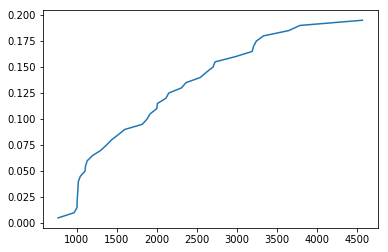

In [79]:
first_ejections_times = []
for result in results:
    if result[2]:
        first_ejections_times.append(result[2][0][-1])

first_ejections_times.sort()
fraction_ejections = np.arange(1, len(first_ejections_times) + 1) / len(results)

plt.plot(first_ejections_times, fraction_ejections).savefig("fraction_first_ejection_vs_time_eject_10_5")    

In [ ]:
[dict(sim: sim,
      intruder: intruder
    close_enocunters: [t, t, t,],
    escapes: [],
      v_escapes: [],
     kozai: [],
     orbit_crossing: []
    ), ..., ..., ..., ...,]

In [75]:
total_ejections = 0
for result in results:
    if result[2]:
        total_ejections += 1


In [6]:
39/200

0.195

In [6]:
def hill_radius(planet, star):
    return planet.a * (1 - planet.e) * np.cbrt(planet.m / (3. * star.m))

In [13]:
def calc_mutual_hill_radii_matrix(sim):
    host_star = sim.particles[0]
    
    hill_radii = np.zeros((len(sim.particles[1:]), len(sim.particles[1:])))

    # find largest mutual hill radius in sim
    for i, planet_1 in enumerate(sim.particles[1:]):
        for j, planet_2 in enumerate(sim.particles[i+2:]):
            j = j + i + 1
            print(i,j)
            mutual_hill_radius = calc_mutual_hill_radius(planet_1, planet_2, host_star.m)
            hill_radii[i][j] = mutual_hill_radius
            hill_radii[j][i] = mutual_hill_radius
    
    return hill_radii

# TEST
calc_mutual_hill_radii_matrix(sim)
    

NameError: name 'sim' is not defined

In [12]:
def calc_mutual_hill_radius(p1, p2, m_host):
    """
    Calculates mutual Hill radius of particle 1 and 2.
    """
    mutual_hill_radius = (p1.a + p2.a) / 2. * np.cbrt((p1.m + p2.m) / (3. * m_host))
    return mutual_hill_radius
    

In [11]:
a

In [7]:
def strong_regime(resolution=100, n_trials=50):
    print("Starting strong regime simulation with resolution {}, {} trials each...".format(resolution, n_trials))
    xs = np.linspace(1, 50, resolution)
    f_eject = np.ones(resolution)
    
    for i, x in enumerate(xs):
        print("Running r_min =", x)
        eject_count = 0.
        
        # run n_trials trials detecting ejection directly after fly-by
        for j in range(n_trials):
            # get a fresh simulation
            sim = rebound.Simulation.from_file("solar_system_outer_planets.bin")
            sim = randomize_sim(sim)
            
            intruder = rebound.Particle(m=1.,x=x,y=-1000.,vy=2.)
            
            sim = simulate_fly_by(sim, intruder)
            
            sim.move_to_hel()
            for particle in sim.particles:
                v = np.linalg.norm(particle.vxyz)
                v_esc = calc_escape_velocity(sim, particle)
                if v > v_esc:
                    eject_count += 1
                    break
        print("Detected", eject_count, "ejections out of", n_trials, "trials.")
        f_eject[i] = eject_count / n_trials
        print(f_eject[i])

    
    return (xs, f_eject)            

Let's define a function to predict the stabillity of a system directly after a fly-by.

Instabillity can be defined in a number of ways. The simplest being direct ejection from the system.

This function will try to analyze the stability of a system based on direct observations of it's orbits properties.

In [9]:
def analyze_stability(sim):
    """Check stabillity of an orbit return True if (possibly) stable, False if unstable"""
    
    if check_immediate_ejection(sim) == True:
        return False
    
    elif check_orbit_crossing(sim) == True:
        return False
    
    elif check_kozai(sim) == True:
        return False
    
    elif check_AMD(sim) == True:
        return False
    
    else:
        return True
    

In [8]:
def check_immediate_ejection(sim):
    # move to Sun frame
    sim.move_to_hel()
    
    # calculate velocity of each particle and compare to escpae velocity
    for particle in sim.particles[1:]:
        v = np.linalg.norm(particle.vxyz)
        v_esc = calc_escape_velocity(sim, particle)
        if v >= v_esc:
            sim.move_to_com()
            return True
        
    sim.move_to_com()
    
    return False
    


In [19]:
sim = rebound.Simulation()
sim.add(m=1.)


In [7]:
def check_kozai(sim):
    # compare all particles
    for i, particle_1 in enumerate(sim.particles[1:]):
        for j, particle_2 in enumerate(sim.particles[i:]):
            # calculate mutual inclination. defined as difference in inclination between two orbits
            mutual_inclination = abs(particle_1.inc - particle_2.inc)
            # check if mutual inclination is between 39.2 degrees and 140.2 degrees
            if 0.684 <  mutual_inclination and mutual_inclination < 2.46:
                return True
    
    return False
            

In [10]:
xs, f_eject = strong_regime(resolution=30, n_trials=100)


plt.plot(xs, f_eject)

Starting strong regime simulation with resolution 30, 100 trials each...
Running r_min = 1.0


NameError: name 'simulate_fly_by' is not defined

In [2]:
import matplotlib.pyplot as plt


NameError: name 'xs' is not defined

In [32]:
a = np.ones(10)
a[2] = 5
a


array([1., 1., 5., 1., 1., 1., 1., 1., 1., 1.])

In [9]:
def randomize_sim(sim):
    sim.integrate(np.random.random()*10**3)
    return sim
    

In [60]:
sim = rebound.Simulation.from_file("solar_system_outer_planets.bin")
intruder = rebound.Particle(m=1.,x=x,y=-1000.,vy=2.)
simulate_fly_by(sim, intruder, visualize=True)

In [13]:
sim.particles[4].inc

0.030897078503559147

In [10]:
def mutual_rhill(p1, p2):
    """
    Calculates mutual Hill radius of particle 1 and 2.
    """
    rhill_m = (p1.a + p2.a) / 2. * ((p1.m + p2.m) / 3.)**(1/3.)
    return rhill_m


def orbit_list(simulation, period, particle, step_size):
    """
    Creates list of points on an orbit.
    """

    locations = []
    total_time = 0
#     Temporary simulation, adding sun and the particle we want the orbit from
    temp_sim = rebound.Simulation()
    temp_sim.add(simulation.particles[0])
    temp_sim.add(particle)
    
#     Integrating over exactly one orbit
    while total_time < period:
        temp_sim.integrate(temp_sim.t+step_size)
        total_time += step_size
        locations.append(temp_sim.particles[1].xyz)
    return np.array(locations)


def check_orbit_crossing(simulation):
    """
    Checks in a simulation whether any orbits cross.
    """

#     Creating and saving lists with points on orbits
    locationslist = []
    for i, particle in enumerate(simulation.particles[1:]):
        orbit = particle.calculate_orbit()
        step_size = orbit.P * orbit.rhill / (2 * np.pi * orbit.a)
        locationslist.append(orbit_list(simulation,
                                        abs(orbit.P), particle.copy(), abs(step_size)))

#     creating distance matrix
    for i, loc1 in enumerate(locationslist):
        for j, loc2 in enumerate(locationslist[i+1:]):
            dist_mat = spatial.distance_matrix(loc1, loc2)
            if dist_mat[np.where(dist_mat < mutual_rhill(simulation.particles[i+1],
                    simulation.particles[j+i+2]))].size > 0:
                # print(f"Planet {i+1} and {i+j+2} (counting from star) will collide!")
                return True

    return False


def check_immediate_ejection(sim):
    """
    Checks whether there is a planet in the simulation with v > v_escape.
    """

    # move to Sun frame
    sim.move_to_hel()

    # calculate velocity of each particle and compare to escpae velocity
    for particle in sim.particles[1:]:
        v = np.linalg.norm(particle.vxyz)
        v_esc = calc_escape_velocity(sim, particle)
        if v >= v_esc:
            sim.move_to_com()
            return True

    sim.move_to_com()
    return False


def check_kozai(sim):
    """
    Checks whether the kozai mechanism is happening in a simulation.
    """

    # compare all particles except the star
    for i, particle_1 in enumerate(sim.particles[1:]):
        for j, particle_2 in enumerate(sim.particles[i+2:]):
            # calculate mutual inclination. defined as difference in inclination between two orbits
            mutual_inclination = abs(particle_1.inc - particle_2.inc)
            # check if mutual inclination is between 39.2 degrees and 140.2 degrees
            if 0.684 <  mutual_inclination and mutual_inclination < 2.46:
                return True

    return False



def randomize_sim(sim):
    """
    Integrates simulation for any number of time between 0 and 999.
    """
    sim.integrate(random.randint(0, 999))
    return sim


def analyze_stability(sim):

    if check_immediate_ejection(sim) == True:
        print("v > v_esc")
        return False

    elif check_orbit_crossing(sim) == True:
        print("orbit crossing")
        return False

    elif check_kozai(sim) == True:
        print("Kozai mechanism activated")
        return False

    else:
        return True